# * TVS Performance

## Import Data Source

In [42]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from functools import reduce
import datetime

mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

In [43]:
as_week = 2023025
data_src = f"../../data/raw/Raw-Agg Perf Nationwide_Wk {as_week}.csv"
df = pd.read_csv(data_src, low_memory=False)
cols = ['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'ACTUAL_AS_OF', 'AGG_TYPE', 'RR_IND', 'GRY_IND', 'UOM', 'PERIOD', 'ACTUAL_SNAP', 'ACTUAL_AGG', 'TARGET_SNAP', 'TARGET_AGG', 'PPN_TM']
df = df[cols]

''' Fix Metric CD List '''
tvs_rev_cd_list = ['TB4R000100', 'TB4R000101', 'TB4R000102']
tvs_sub_cd_list = ['TB4S000400', 'TB4S000500']
tvs_new_sub_cd_list = ['TB4S000100', 'TB4S000101', 'TB4S000102', 'TB4S000103', 'TB4S000104']
tvs_churn_cd_list = ['TSER14100'] # Data absent
tvs_all_cd_list = tvs_rev_cd_list + tvs_sub_cd_list + tvs_new_sub_cd_list + tvs_churn_cd_list

In [44]:
df.shape

(67968, 22)

In [45]:
''' Find Metric '''

df_agg_s = df[df['AGG_TYPE']=='S'].groupby(['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE']).agg({'ACTUAL_SNAP': 'sum', 'TARGET_SNAP': 'sum'}).reset_index()
# df_agg_n = df.loc[df[(df['AGG_TYPE']=='N') & (df['ACTUAL_SNAP']>0)].groupby('METRIC_CD')['TM_KEY_DAY'].idxmax()].reset_index()
df_agg_n = df.loc[df[df['AGG_TYPE']=='N'].groupby('METRIC_CD')['TM_KEY_DAY'].idxmax()].reset_index()
df_agg_n = df_agg_n[['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE', 'ACTUAL_AGG', 'TARGET_AGG']]
df_metric = pd.concat([df_agg_s, df_agg_n])
# df_metric['ACTUAL_SNAP'] = df_metric['ACTUAL_SNAP']/1000000
# df_metric['TARGET_SNAP'] = df_metric['TARGET_SNAP']/1000000
# df_metric

df_tmp = df_metric[df_metric['PRODUCT_GRP']=="TVS"]#.reset_index()
# df_tmp = df_tmp[df_tmp['CENTER']=="Sales & Revenue"]
# df_tmp = df_tmp[df_tmp['METRIC_GRP']=="Revenue"]
# df_tmp = df_tmp[df_tmp['METRIC_GRP']=="Subs"]
# df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Revenue")].reset_index()
df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Sub")]#.reset_index()

df_tmp.sort_values(by=['CENTER', 'METRIC_GRP', 'COMP_CD', 'METRIC_CD'])
# df_tmp.to_excel('TVS_Metric.xlsx', index=False)

,CENTER,METRIC_GRP,COMP_CD,PRODUCT_GRP,METRIC_CD,METRIC_NAME,AGG_TYPE,ACTUAL_SNAP,TARGET_SNAP,ACTUAL_AGG,TARGET_AGG
38,Customer Service Experience & Retention,Retention & Churn,TRUE,TVS,TSER14100,TVS Churn Subs,S,0.0,0.000,NaN,NaN
39,Customer Service Experience & Retention,Retention & Churn,TRUE,TVS,TSER14102,TVS Churn Subs Voluntary,S,0.0,0.000,NaN,NaN
40,Customer Service Experience & Retention,Retention & Churn,TRUE,TVS,TSER14103,TVS Churn Subs Involuntary,S,0.0,0.000,NaN,NaN
71,Digitalization,Digitalization,TRUE,TVS,DIS10025,% TVS Subs on True iService (Bills & Usage),N,NaN,NaN,NaN,NaN
282,Sales & Revenue,Sales,TRUE,TVS,TB4S000100,TVS New Subs,S,25147.0,38773.583,NaN,NaN
283,Sales & Revenue,Sales,TRUE,TVS,TB4S000101,TVS New Subs : Premium,S,4107.0,0.000,NaN,NaN
284,Sales & Revenue,Sales,TRUE,TVS,TB4S000102,TVS New Subs : Mid,S,3546.0,0.000,NaN,NaN
285,Sales & Revenue,Sales,TRUE,TVS,TB4S000103,TVS New Subs Mass,S,17494.0,0.000,NaN,NaN
286,Sales & Revenue,Sales,TRUE,TVS,TB4S000104,TVS New Subs TVS Now,S,7601.0,0.000,NaN,NaN
110,Sales & Revenue,Subs,TRUE,TVS,TB4S000500,TVS Active Subs,N,NaN,NaN,3563729.0,1429901.3


## Data Preporation

In [46]:
''' Functions '''

def unit_mb(baht):
    n = baht
    unit_mb = n / 1000000
    return unit_mb

def unit_k(baht):
    n = baht
    unit_k = n / 1000
    return unit_k

In [47]:
''' Rawdata '''

''' Filters '''
# df = df[df['TM_KEY_MTH'] <= 202305] # MONTH filter
# df = df[df['TM_KEY_WK'] <= 2023022] # WEEK filter
# df = df[df['TM_KEY_DAY'] <= 20230618] # DAY filter
df = df[df['METRIC_CD'].isin(tvs_all_cd_list)]

''' Modify '''
df = df.rename(columns={'ACTUAL_SNAP':'ACT_SNAP', 'ACTUAL_AGG':'ACT_AGG', 'TARGET_SNAP':'TGT_SNAP', 'TARGET_AGG':'TGT_AGG'})

''' Add new column '''
df['MTH_DESC'] = pd.to_datetime(df['TM_KEY_MTH'], format='%Y%m', errors='coerce').dt.strftime('%B')
df['WK_LABEL'] = df['TM_KEY_WK'].apply(str).str[5:].astype(int)
df['DAY_LABEL'] = df['TM_KEY_DAY'].apply(str).str[6:].astype(int)

df.tail(3)

,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,CENTER,METRIC_GRP,COMP_CD,PRODUCT_GRP,METRIC_CD,...,UOM,PERIOD,ACT_SNAP,ACT_AGG,TGT_SNAP,TGT_AGG,PPN_TM,MTH_DESC,WK_LABEL,DAY_LABEL
62967,20230625,2023025,202306,20232,2023,Sales & Revenue,Revenue,TRUE,TVS,TB4R000100,...,baht,M,25448451.94,218760957.7,2.893928e+07,2.491767e+08,2023-06-28 17:48:36,June,25,25
62968,20230626,2023026,202306,20232,2023,Sales & Revenue,Revenue,TRUE,TVS,TB4R000100,...,baht,M,NaN,218760957.7,NaN,2.491767e+08,2023-06-28 17:48:36,June,26,26
62969,20230627,2023026,202306,20232,2023,Sales & Revenue,Revenue,TRUE,TVS,TB4R000100,...,baht,M,NaN,218760957.7,NaN,2.491767e+08,2023-06-28 17:48:36,June,26,27


In [48]:
''' Create Dataframe '''

''' Aggregate type : S '''
df_agg_s = df[df['AGG_TYPE']=='S']
df_agg_s = df_agg_s.rename(columns={'ACT_SNAP':'ACT', 'TGT_SNAP':'TGT'})

''' Aggregate type : N '''
df_agg_n = df[df['AGG_TYPE']=='N'].dropna(subset='ACT_SNAP')
df_agg_n = df_agg_n.rename(columns={'ACT_SNAP':'ACT', 'TGT_SNAP':'TGT'})

In [49]:
''' Period Values '''

curr_yr = df['TM_KEY_YR'].max()
last_yr = df['TM_KEY_YR'].max() - 1
curr_mth = df['TM_KEY_MTH'].max()
curr_mth_desc = pd.to_datetime(curr_mth, format='%Y%m', errors='coerce').strftime('%B')
last_mth = int(f'{str(last_yr)}12') if str(curr_mth)[4:]=='01' else curr_mth-1
curr_wk = df['TM_KEY_WK'].max()
last_wk = df['TM_KEY_WK'].drop_duplicates().shift().max()
curr_wk_label = df['WK_LABEL'].iloc[-1]
curr_day = df['TM_KEY_DAY'].max()
last_day = df['TM_KEY_DAY'].drop_duplicates().shift().max()
curr_day_label = df['DAY_LABEL'].iloc[-1]
last_ppn_tm = df['PPN_TM'].max()

wk_day_start = int(str(df[df['TM_KEY_WK']==curr_wk]['TM_KEY_DAY'].min())[6:])
wk_day_end = int(str(df[df['TM_KEY_WK']==curr_wk]['TM_KEY_DAY'].max())[6:])

### DAY : Aggregation (base level)

In [50]:
''' Create Dataframe '''

cols_agg = ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'MTH_DESC', 'DAY_LABEL', 'AGG_TYPE', 'ACT_SNAP', 'ACT_AGG', 'TGT_SNAP', 'TGT_AGG']
df_rev_day = df[cols_agg].reset_index()

''' Aggregation '''
df_rev_day['ACT'] = np.where(df_rev_day['AGG_TYPE']=='N', df_rev_day['ACT_AGG'], df_rev_day['ACT_SNAP'])
df_rev_day['TGT'] = np.where(df_rev_day['AGG_TYPE']=='N', df_rev_day['TGT_AGG'], df_rev_day['TGT_SNAP'])
df_rev_day['%ACHV'] = df_rev_day['ACT'] / df_rev_day['TGT']
df_rev_day['GAP'] = df_rev_day['ACT'] - df_rev_day['TGT']
df_rev_day['LAST_ACT'] = df_rev_day.groupby('METRIC_CD')['ACT'].shift()
df_rev_day['DIFF'] = df_rev_day['ACT'] - df_rev_day['LAST_ACT']
df_rev_day['%DOD'] = (df_rev_day['ACT'] / df_rev_day['LAST_ACT']) - 1

# df_rev_day.to_excel('df_rev_day.xlsx', index=False)
df_rev_day.tail(3)

,index,METRIC_CD,METRIC_NAME,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,MTH_DESC,DAY_LABEL,...,ACT_AGG,TGT_SNAP,TGT_AGG,ACT,TGT,%ACHV,GAP,LAST_ACT,DIFF,%DOD
1306,62967,TB4R000100,TVS Revenue,20230625,2023025,202306,20232,2023,June,25,...,218760957.7,2.893928e+07,2.491767e+08,25448451.94,2.893928e+07,0.879374,-3.490827e+06,NaN,NaN,NaN
1307,62968,TB4R000100,TVS Revenue,20230626,2023026,202306,20232,2023,June,26,...,218760957.7,NaN,2.491767e+08,NaN,NaN,NaN,NaN,25448451.94,NaN,NaN
1308,62969,TB4R000100,TVS Revenue,20230627,2023026,202306,20232,2023,June,27,...,218760957.7,NaN,2.491767e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
df_rev_day['METRIC_NAME'].unique()

array(['TVS Active Subs', 'TVS Churn Subs', 'TVS Exisitng Revenue',
       'TVS Net Add', 'TVS New Revenue', 'TVS New Subs',
       'TVS New Subs : Mid', 'TVS New Subs : Premium',
       'TVS New Subs Mass', 'TVS New Subs TVS Now', 'TVS Revenue'],
      dtype=object)

In [52]:
''' Fix Columns Dict '''

cols_dict = {'TVS Revenue':'TOTAL', 'TVS New Revenue':'NEW', 'TVS Exisitng Revenue':'EXIST', 
             'TVS Net Add':'NET_ADD', 'TVS Active Subs':'ACTV_SUB', 'TVS Churn Subs':'CHRN_SUB', 
             'TVS New Subs':'NEW_SUB', 'TVS New Subs : Premium':'NEW_SUB_PREM', 'TVS New Subs : Mid':'NEW_SUB_MID', 'TVS New Subs Mass':'NEW_SUB_MASS', 'TVS New Subs TVS Now':'NEW_SUB_NOW'}

In [53]:
''' Pivot by KPIS '''

df_rev_day_agg = df_rev_day.pivot(index=['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'MTH_DESC', 'DAY_LABEL'], columns='METRIC_NAME', 
                                  values=['ACT', 'TGT', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%DOD']).rename(columns=cols_dict).reset_index()
df_rev_day_agg.tail(3)

TM_KEY_DAY TM_KEY_WK TM_KEY_MTH TM_KEY_QTR TM_KEY_YR MTH_DESC  \
METRIC_NAME                                                                 
116           20230625   2023025     202306      20232      2023     June   
117           20230626   2023026     202306      20232      2023     June   
118           20230627   2023026     202306      20232      2023     June   

            DAY_LABEL        ACT                        ...     %DOD        \
METRIC_NAME             ACTV_SUB CHRN_SUB        EXIST  ... CHRN_SUB EXIST   
116                25  3562101.0      NaN  23498070.67  ...      NaN   NaN   
117                26  3561235.0      NaN          NaN  ...      NaN   NaN   
118                27  3563729.0      NaN          NaN  ...      NaN   NaN   

                                                                         \
METRIC_NAME NET_ADD NEW   NEW_SUB NEW_SUB_MID NEW_SUB_PREM NEW_SUB_MASS   
116             NaN NaN -0.107692   -0.157895    -0.088889    -0.103306   
117             NaN NaN  0.003448    0.187500     0.219512    -0.064516   
118             NaN NaN -0.130584   -0.578947     0.080000    -0.098522   

                               
METRIC_NAME NEW_SUB_NOW TOTAL  
116            1.222222   NaN  
117            0.000000   NaN  
118                 NaN   NaN  

[3 rows x 84 columns]

## ** Yearly **

### YR : Aggregation

In [54]:
''' Create Dataframe '''

df_agg_s_yr = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_YR', 'AGG_TYPE']).agg({'ACT': 'sum', 'TGT': 'sum'}).reset_index()
df_agg_n_yr = df_agg_n.loc[df_agg_n.groupby('TM_KEY_YR')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_YR', 'AGG_TYPE', 'ACT', 'TGT']]
df_rev_yr = pd.concat([df_agg_s_yr, df_agg_n_yr])

''' Aggregation '''
df_rev_yr['%ACHV'] = np.where(df_rev_yr['METRIC_NAME']=='TVS Churn Subs', -((df_rev_yr['ACT']/df_rev_yr['TGT'])-1), df_rev_yr['ACT']/df_rev_yr['TGT'])
df_rev_yr['GAP'] = df_rev_yr['ACT'] - df_rev_yr['TGT']
df_rev_yr['LAST_ACT'] = df_rev_yr.groupby('METRIC_CD')['ACT'].shift()
df_rev_yr['DIFF'] = df_rev_yr['ACT'] - df_rev_yr['LAST_ACT']
df_rev_yr['%YOY'] = (df_rev_yr['ACT'] / df_rev_yr['LAST_ACT']) - 1

df_rev_yr#.tail()

,METRIC_CD,METRIC_NAME,TM_KEY_YR,AGG_TYPE,ACT,TGT,%ACHV,GAP,LAST_ACT,DIFF,%YOY
0,TB4R000100,TVS Revenue,2023,S,1.140805e+09,1.490026e+09,0.765628,-3.492208e+08,NaN,NaN,NaN
1,TB4R000101,TVS New Revenue,2023,S,5.111504e+07,1.442993e+08,0.354229,-9.318424e+07,NaN,NaN,NaN
2,TB4R000102,TVS Exisitng Revenue,2023,S,1.090144e+09,1.355379e+09,0.804309,-2.652349e+08,NaN,NaN,NaN
3,TB4S000100,TVS New Subs,2023,S,2.514700e+04,3.877358e+04,0.648560,-1.362658e+04,NaN,NaN,NaN
4,TB4S000101,TVS New Subs : Premium,2023,S,4.107000e+03,0.000000e+00,inf,4.107000e+03,NaN,NaN,NaN
5,TB4S000102,TVS New Subs : Mid,2023,S,3.546000e+03,0.000000e+00,inf,3.546000e+03,NaN,NaN,NaN
6,TB4S000103,TVS New Subs Mass,2023,S,1.749400e+04,0.000000e+00,inf,1.749400e+04,NaN,NaN,NaN
7,TB4S000104,TVS New Subs TVS Now,2023,S,7.601000e+03,0.000000e+00,inf,7.601000e+03,NaN,NaN,NaN
8,TB4S000400,TVS Net Add,2023,S,0.000000e+00,0.000000e+00,NaN,0.000000e+00,NaN,NaN,NaN
9,TSER14100,TVS Churn Subs,2023,S,0.000000e+00,0.000000e+00,NaN,0.000000e+00,NaN,NaN,NaN


In [55]:
''' Pivot by KPIS '''

df_rev_yr_agg = df_rev_yr.pivot(index='TM_KEY_YR', columns='METRIC_NAME', 
                                values=['ACT', 'TGT', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%YOY']).rename(columns=cols_dict).reset_index()
df_rev_yr_agg.tail(3)

TM_KEY_YR        ACT                                             \
METRIC_NAME             ACTV_SUB CHRN_SUB         EXIST NET_ADD         NEW   
0                2023  3563729.0      0.0  1.090144e+09     0.0  51115040.3   

                                                            ...     %YOY  \
METRIC_NAME  NEW_SUB NEW_SUB_MID NEW_SUB_PREM NEW_SUB_MASS  ... CHRN_SUB   
0            25147.0      3546.0       4107.0      17494.0  ...      NaN   

                                                                             \
METRIC_NAME EXIST NET_ADD NEW NEW_SUB NEW_SUB_MID NEW_SUB_PREM NEW_SUB_MASS   
0             NaN     NaN NaN     NaN         NaN          NaN          NaN   

                               
METRIC_NAME NEW_SUB_NOW TOTAL  
0                   NaN   NaN  

[1 rows x 78 columns]

In [56]:
''' YTD Values '''

day_cnt_curr_yr = len(df_rev_day_agg[df_rev_day_agg['TM_KEY_YR']==curr_yr]['TM_KEY_DAY'].unique())
day_cnt_last_yr = len(df_rev_day_agg[df_rev_day_agg['TM_KEY_YR']==last_yr]['TM_KEY_DAY'].unique())

''' Last Period : Values '''
last_yr_rev = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==last_yr]['ACT']['TOTAL'].sum()
last_yr_rev_new = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==last_yr]['ACT']['NEW'].sum()
last_yr_rev_exist = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==last_yr]['ACT']['EXIST'].sum()
last_yr_actv_sub = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==last_yr]['ACT']['ACTV_SUB'].sum()
last_yr_chrn_sub = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==last_yr]['ACT']['CHRN_SUB'].sum()
last_yr_net_add = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==last_yr]['ACT']['NET_ADD'].sum()
last_yr_new_sub = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==last_yr]['ACT']['NEW_SUB'].sum()
last_yr_new_sub_prem = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==last_yr]['ACT']['NEW_SUB_PREM'].sum()
last_yr_new_sub_mid = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==last_yr]['ACT']['NEW_SUB_MID'].sum()
last_yr_new_sub_mass = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==last_yr]['ACT']['NEW_SUB_MASS'].sum()
last_yr_new_sub_now = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==last_yr]['ACT']['NEW_SUB_NOW'].sum()

''' TOTAL : Values '''
ytd_rev = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==curr_yr]['ACT']['TOTAL'].sum()
ytd_tgt = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==curr_yr]['TGT']['TOTAL'].sum()
ytd_achv = ytd_rev / ytd_tgt
ytd_last_rev = (last_yr_rev / day_cnt_last_yr) * day_cnt_curr_yr
ytd_yoy = (ytd_rev / ytd_last_rev) - 1
ytd_gap = ytd_rev - ytd_last_rev

''' NEW : Values '''
ytd_rev_new = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==curr_yr]['ACT']['NEW'].sum()
ytd_tgt_new = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==curr_yr]['TGT']['NEW'].sum()
ytd_achv_new = ytd_rev_new / ytd_tgt_new
ytd_last_rev_new = (last_yr_rev_new / day_cnt_last_yr) * day_cnt_curr_yr
ytd_yoy_new = (ytd_rev_new / ytd_last_rev_new) - 1
ytd_gap_new = ytd_rev_new - ytd_last_rev_new

''' EXIST : Values '''
ytd_rev_exist = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==curr_yr]['ACT']['EXIST'].sum()
ytd_tgt_exist = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==curr_yr]['TGT']['EXIST'].sum()
ytd_achv_exist = ytd_rev_exist / ytd_tgt_exist
ytd_last_rev_exist = (last_yr_rev_exist / day_cnt_last_yr) * day_cnt_curr_yr
ytd_yoy_exist = (ytd_rev_exist / ytd_last_rev_exist) - 1
ytd_gap_exist = ytd_rev_exist - ytd_last_rev_exist

''' ACTV_SUB : Values '''
ytd_actv_sub = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==curr_yr]['ACT']['ACTV_SUB'].sum()
ytd_tgt_actv_sub = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==curr_yr]['TGT']['ACTV_SUB'].sum()
ytd_achv_actv_sub = ytd_actv_sub / ytd_tgt_actv_sub
ytd_last_actv_sub = (last_yr_actv_sub / day_cnt_last_yr) * day_cnt_curr_yr
ytd_yoy_actv_sub = (ytd_actv_sub / ytd_last_actv_sub) - 1
ytd_gap_actv_sub = ytd_actv_sub - ytd_last_actv_sub

''' CHRN_SUB : Values '''
ytd_chrn_sub = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==curr_yr]['ACT']['CHRN_SUB'].sum()
ytd_tgt_chrn_sub = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==curr_yr]['TGT']['CHRN_SUB'].sum()
ytd_achv_chrn_sub = -((ytd_chrn_sub / ytd_tgt_chrn_sub) - 1)
ytd_last_chrn_sub = (last_yr_chrn_sub / day_cnt_last_yr) * day_cnt_curr_yr
ytd_yoy_chrn_sub = (ytd_chrn_sub / ytd_last_chrn_sub) - 1
ytd_gap_chrn_sub = ytd_chrn_sub - ytd_last_chrn_sub

''' NET_ADD : Values '''
ytd_net_add = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==curr_yr]['ACT']['NET_ADD'].sum()
ytd_tgt_net_add = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==curr_yr]['TGT']['NET_ADD'].sum()
ytd_achv_net_add = ytd_net_add / ytd_tgt_net_add
ytd_last_net_add = (last_yr_net_add / day_cnt_last_yr) * day_cnt_curr_yr
ytd_yoy_net_add = (ytd_net_add / ytd_last_net_add) - 1
ytd_gap_net_add = ytd_net_add - ytd_last_net_add

''' NEW_SUB : Values '''
ytd_new_sub = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==curr_yr]['ACT']['NEW_SUB'].sum()
ytd_tgt_new_sub = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==curr_yr]['TGT']['NEW_SUB'].sum()
ytd_achv_new_sub = ytd_new_sub / ytd_tgt_new_sub
ytd_last_new_sub = (last_yr_new_sub / day_cnt_last_yr) * day_cnt_curr_yr
ytd_yoy_new_sub = (ytd_new_sub / ytd_last_new_sub) - 1
ytd_gap_new_sub = ytd_new_sub - ytd_last_new_sub

''' NEW_SUB_PREM : Values '''
ytd_new_sub_prem = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==curr_yr]['ACT']['NEW_SUB_PREM'].sum()
ytd_tgt_new_sub_prem = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==curr_yr]['TGT']['NEW_SUB_PREM'].sum()
ytd_achv_new_sub_prem = ytd_new_sub_prem / ytd_tgt_new_sub_prem
ytd_last_new_sub_prem = (last_yr_new_sub_prem / day_cnt_last_yr) * day_cnt_curr_yr
ytd_yoy_new_sub_prem = (ytd_new_sub_prem / ytd_last_new_sub_prem) - 1
ytd_gap_new_sub_prem = ytd_new_sub_prem - ytd_last_new_sub_prem

''' NEW_SUB_MID : Values '''
ytd_new_sub_mid = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==curr_yr]['ACT']['NEW_SUB_MID'].sum()
ytd_tgt_new_sub_mid = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==curr_yr]['TGT']['NEW_SUB_MID'].sum()
ytd_achv_new_sub_mid = ytd_new_sub_mid / ytd_tgt_new_sub_mid
ytd_last_new_sub_mid = (last_yr_new_sub_mid / day_cnt_last_yr) * day_cnt_curr_yr
ytd_yoy_new_sub_mid = (ytd_new_sub_mid / ytd_last_new_sub_mid) - 1
ytd_gap_new_sub_mid = ytd_new_sub_mid - ytd_last_new_sub_mid

''' NEW_SUB_MASS : Values '''
ytd_new_sub_mass = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==curr_yr]['ACT']['NEW_SUB_MASS'].sum()
ytd_tgt_new_sub_mass = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==curr_yr]['TGT']['NEW_SUB_MASS'].sum()
ytd_achv_new_sub_mass = ytd_new_sub_mass / ytd_tgt_new_sub_mass
ytd_last_new_sub_mass = (last_yr_new_sub_mass / day_cnt_last_yr) * day_cnt_curr_yr
ytd_yoy_new_sub_mass = (ytd_new_sub_mass / ytd_last_new_sub_mass) - 1
ytd_gap_new_sub_mass = ytd_new_sub_mass - ytd_last_new_sub_mass

''' NEW_SUB_NOW : Values '''
ytd_new_sub_now = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==curr_yr]['ACT']['NEW_SUB_NOW'].sum()
ytd_tgt_new_sub_now = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==curr_yr]['TGT']['NEW_SUB_NOW'].sum()
ytd_achv_new_sub_now = ytd_new_sub_now / ytd_tgt_new_sub_now
ytd_last_new_sub_now = (last_yr_new_sub_now / day_cnt_last_yr) * day_cnt_curr_yr
ytd_yoy_new_sub_now = (ytd_new_sub_now / ytd_last_new_sub_now) - 1
ytd_gap_new_sub_now = ytd_new_sub_now - ytd_last_new_sub_now

C:\Users\Narut4\AppData\Local\Temp\ipykernel_10600\1314697106.py:23: RuntimeWarning: invalid value encountered in scalar divide
  ytd_last_rev = (last_yr_rev / day_cnt_last_yr) * day_cnt_curr_yr
C:\Users\Narut4\AppData\Local\Temp\ipykernel_10600\1314697106.py:31: RuntimeWarning: invalid value encountered in scalar divide
  ytd_last_rev_new = (last_yr_rev_new / day_cnt_last_yr) * day_cnt_curr_yr
C:\Users\Narut4\AppData\Local\Temp\ipykernel_10600\1314697106.py:39: RuntimeWarning: invalid value encountered in scalar divide
  ytd_last_rev_exist = (last_yr_rev_exist / day_cnt_last_yr) * day_cnt_curr_yr
C:\Users\Narut4\AppData\Local\Temp\ipykernel_10600\1314697106.py:47: RuntimeWarning: invalid value encountered in scalar divide
  ytd_last_actv_sub = (last_yr_actv_sub / day_cnt_last_yr) * day_cnt_curr_yr
C:\Users\Narut4\AppData\Local\Temp\ipykernel_10600\1314697106.py:54: RuntimeWarning: invalid value encountered in scalar divide
  ytd_achv_chrn_sub = -((ytd_chrn_sub / ytd_tgt_chrn_sub) - 1)

In [57]:
''' YTD BarH Dataframe'''

df_bar_h_ytd = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==curr_yr]['ACT'][['NEW_SUB', 'NEW_SUB_NOW', 'CHRN_SUB', 'NET_ADD']].T.reset_index()
df_bar_h_ytd.columns = ['METRIC_NAME', 'VALUES']

color_conditions = [df_bar_h_ytd['METRIC_NAME']=='NEW_SUB', 
                    df_bar_h_ytd['METRIC_NAME']=='NEW_SUB_NOW', 
                    df_bar_h_ytd['METRIC_NAME']=='CHRN_SUB', 
                    df_bar_h_ytd['METRIC_NAME']=='NET_ADD',]
color_results = ['limegreen', 'turquoise', 'lightcoral', 'gold']
sort_results = [1, 2, 3, 4]

df_bar_h_ytd['COLOR'] = np.select(color_conditions, color_results)
df_bar_h_ytd['SORT_NO'] = np.select(color_conditions, sort_results)

df_bar_h_ytd = df_bar_h_ytd.sort_values(by='SORT_NO', ascending=False)
df_bar_h_ytd

,METRIC_NAME,VALUES,COLOR,SORT_NO
3,NET_ADD,0.0,gold,4
2,CHRN_SUB,0.0,lightcoral,3
1,NEW_SUB_NOW,7601.0,turquoise,2
0,NEW_SUB,25147.0,limegreen,1


In [58]:
''' Year Chart Values '''

x_yr = df_rev_yr_agg['TM_KEY_YR']
x_yr_axis = np.arange(len(x_yr))

''' TOTAL : Values '''
y_yr_act = df_rev_yr_agg['ACT']['TOTAL']
y_yr_tgt = df_rev_yr_agg['TGT']['TOTAL']
y_yr_achv = df_rev_yr_agg['%ACHV']['TOTAL']
y_yr_gap = df_rev_yr_agg['GAP']['TOTAL']
y_yr_diff = df_rev_yr_agg['DIFF']['TOTAL']
y_yr_last_act = df_rev_yr_agg['LAST_ACT']['TOTAL']
y_yr_yoy = df_rev_yr_agg['%YOY']['TOTAL']

''' NEW : Values '''
y_yr_act_new = df_rev_yr_agg['ACT']['NEW']
y_yr_tgt_new = df_rev_yr_agg['TGT']['NEW']
y_yr_achv_new = df_rev_yr_agg['%ACHV']['NEW']
y_yr_gap_new = df_rev_yr_agg['GAP']['NEW']
y_yr_diff_new = df_rev_yr_agg['DIFF']['NEW']
y_yr_last_act_new = df_rev_yr_agg['LAST_ACT']['NEW']
y_yr_yoy_new = df_rev_yr_agg['%YOY']['NEW']

''' EXIST : Values '''
y_yr_act_exist = df_rev_yr_agg['ACT']['EXIST']
y_yr_tgt_exist = df_rev_yr_agg['TGT']['EXIST']
y_yr_achv_exist = df_rev_yr_agg['%ACHV']['EXIST']
y_yr_gap_exist = df_rev_yr_agg['GAP']['EXIST']
y_yr_diff_exist = df_rev_yr_agg['DIFF']['EXIST']
y_yr_last_act_exist = df_rev_yr_agg['LAST_ACT']['EXIST']
y_yr_yoy_exist = df_rev_yr_agg['%YOY']['EXIST']

''' ACTV_SUB : Values '''
y_yr_act_actv_sub = df_rev_yr_agg['ACT']['ACTV_SUB']
y_yr_tgt_actv_sub = df_rev_yr_agg['TGT']['ACTV_SUB']
y_yr_achv_actv_sub = df_rev_yr_agg['%ACHV']['ACTV_SUB']
y_yr_gap_actv_sub = df_rev_yr_agg['GAP']['ACTV_SUB']
y_yr_diff_actv_sub = df_rev_yr_agg['DIFF']['ACTV_SUB']
y_yr_last_act_actv_sub = df_rev_yr_agg['LAST_ACT']['ACTV_SUB']
y_yr_yoy_actv_sub = df_rev_yr_agg['%YOY']['ACTV_SUB']

''' CHRN_SUB : Values '''
y_yr_act_chrn_sub = df_rev_yr_agg['ACT']['CHRN_SUB']
y_yr_tgt_chrn_sub = df_rev_yr_agg['TGT']['CHRN_SUB']
y_yr_achv_chrn_sub = df_rev_yr_agg['%ACHV']['CHRN_SUB']
y_yr_gap_chrn_sub = df_rev_yr_agg['GAP']['CHRN_SUB']
y_yr_diff_chrn_sub = df_rev_yr_agg['DIFF']['CHRN_SUB']
y_yr_last_act_chrn_sub = df_rev_yr_agg['LAST_ACT']['CHRN_SUB']
y_yr_yoy_chrn_sub = df_rev_yr_agg['%YOY']['CHRN_SUB']

''' NET_ADD : Values '''
y_yr_act_net_add = df_rev_yr_agg['ACT']['NET_ADD']
y_yr_tgt_net_add = df_rev_yr_agg['TGT']['NET_ADD']
y_yr_achv_net_add = df_rev_yr_agg['%ACHV']['NET_ADD']
y_yr_gap_net_add = df_rev_yr_agg['GAP']['NET_ADD']
y_yr_diff_net_add = df_rev_yr_agg['DIFF']['NET_ADD']
y_yr_last_act_net_add = df_rev_yr_agg['LAST_ACT']['NET_ADD']
y_yr_yoy_net_add = df_rev_yr_agg['%YOY']['NET_ADD']

''' NEW_SUB : Values '''
y_yr_act_new_sub = df_rev_yr_agg['ACT']['NEW_SUB']
y_yr_tgt_new_sub = df_rev_yr_agg['TGT']['NEW_SUB']
y_yr_achv_new_sub = df_rev_yr_agg['%ACHV']['NEW_SUB']
y_yr_gap_new_sub = df_rev_yr_agg['GAP']['NEW_SUB']
y_yr_diff_new_sub = df_rev_yr_agg['DIFF']['NEW_SUB']
y_yr_last_act_new_sub = df_rev_yr_agg['LAST_ACT']['NEW_SUB']
y_yr_yoy_new_sub = df_rev_yr_agg['%YOY']['NEW_SUB']

''' NEW_SUB_PREM : Values '''
y_yr_act_new_sub_prem = df_rev_yr_agg['ACT']['NEW_SUB_PREM']
y_yr_tgt_new_sub_prem = df_rev_yr_agg['TGT']['NEW_SUB_PREM']
y_yr_achv_new_sub_prem = df_rev_yr_agg['%ACHV']['NEW_SUB_PREM']
y_yr_gap_new_sub_prem = df_rev_yr_agg['GAP']['NEW_SUB_PREM']
y_yr_diff_new_sub_prem = df_rev_yr_agg['DIFF']['NEW_SUB_PREM']
y_yr_last_act_new_sub_prem = df_rev_yr_agg['LAST_ACT']['NEW_SUB_PREM']
y_yr_yoy_new_sub_prem = df_rev_yr_agg['%YOY']['NEW_SUB_PREM']

''' NEW_SUB_MID : Values '''
y_yr_act_new_sub_mid = df_rev_yr_agg['ACT']['NEW_SUB_MID']
y_yr_tgt_new_sub_mid = df_rev_yr_agg['TGT']['NEW_SUB_MID']
y_yr_achv_new_sub_mid = df_rev_yr_agg['%ACHV']['NEW_SUB_MID']
y_yr_gap_new_sub_mid = df_rev_yr_agg['GAP']['NEW_SUB_MID']
y_yr_diff_new_sub_mid = df_rev_yr_agg['DIFF']['NEW_SUB_MID']
y_yr_last_act_new_sub_mid = df_rev_yr_agg['LAST_ACT']['NEW_SUB_MID']
y_yr_yoy_new_sub_mid = df_rev_yr_agg['%YOY']['NEW_SUB_MID']

''' NEW_SUB_MASS : Values '''
y_yr_act_new_sub_mass = df_rev_yr_agg['ACT']['NEW_SUB_MASS']
y_yr_tgt_new_sub_mass = df_rev_yr_agg['TGT']['NEW_SUB_MASS']
y_yr_achv_new_sub_mass = df_rev_yr_agg['%ACHV']['NEW_SUB_MASS']
y_yr_gap_new_sub_mass = df_rev_yr_agg['GAP']['NEW_SUB_MASS']
y_yr_diff_new_sub_mass = df_rev_yr_agg['DIFF']['NEW_SUB_MASS']
y_yr_last_act_new_sub_mass = df_rev_yr_agg['LAST_ACT']['NEW_SUB_MASS']
y_yr_yoy_new_sub_mass = df_rev_yr_agg['%YOY']['NEW_SUB_MASS']

''' NEW_SUB_NOW : Values '''
y_yr_act_new_sub_now = df_rev_yr_agg['ACT']['NEW_SUB_NOW']
y_yr_tgt_new_sub_now = df_rev_yr_agg['TGT']['NEW_SUB_NOW']
y_yr_achv_new_sub_now = df_rev_yr_agg['%ACHV']['NEW_SUB_NOW']
y_yr_gap_new_sub_now = df_rev_yr_agg['GAP']['NEW_SUB_NOW']
y_yr_diff_new_sub_now = df_rev_yr_agg['DIFF']['NEW_SUB_NOW']
y_yr_last_act_new_sub_now = df_rev_yr_agg['LAST_ACT']['NEW_SUB_NOW']
y_yr_yoy_new_sub_now = df_rev_yr_agg['%YOY']['NEW_SUB_NOW']

### YR : Visualizations

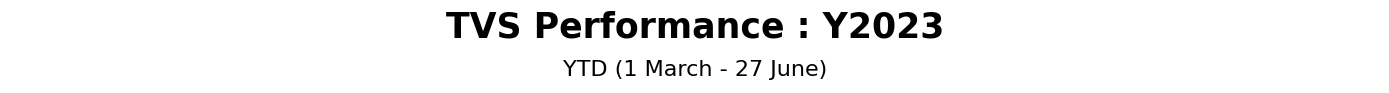

In [59]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

ax1.text(0.5, 0.5, f"TVS Performance : Y{curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"YTD (1 March - {curr_day_label} {curr_mth_desc})", size=16, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

fig.tight_layout()
plt.show()

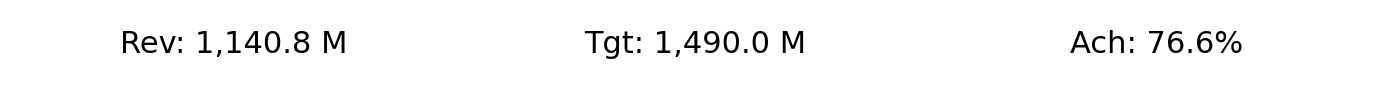

In [60]:
''' YTD Revenue '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
# ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Rev: {format(unit_mb(ytd_rev),',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(ytd_tgt),',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(ytd_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

# ax4.text(0.5, 0.5, f"YoY: {format(ytd_yoy,',.1%')}", size=22, ha='center', va='center')
# ax4.spines[['top','left','right','bottom']].set_visible(False)
# ax4.set_axis_off()

fig.tight_layout()
plt.show()

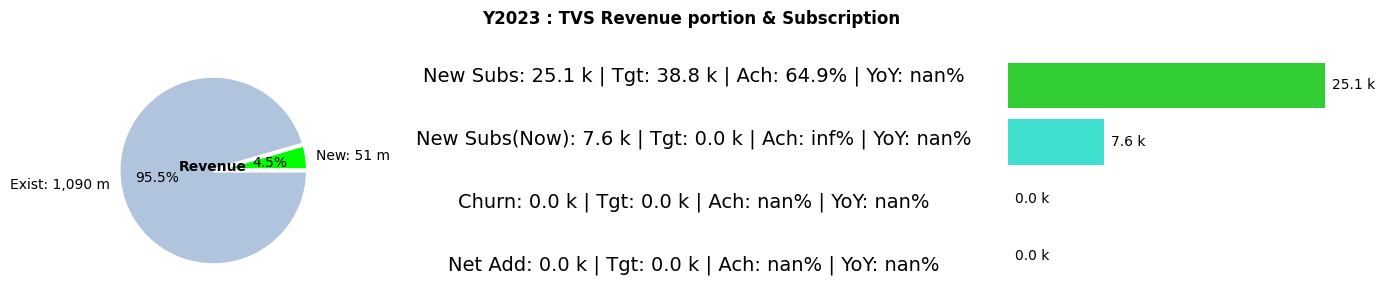

In [61]:
'''' Revenue Portion & Subscription '''

fig = plt.figure(figsize=(14, 3))
fig.suptitle(f'Y{curr_yr} : TVS Revenue portion & Subscription', weight='bold')
gs = GridSpec(4, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[2, 1])
ax5 = fig.add_subplot(gs[3, 1])
ax6 = fig.add_subplot(gs[:, 2])

''' ax1 '''
y = np.array([unit_mb(ytd_rev_new.sum()), unit_mb(ytd_rev_exist.sum())])
mylabels = [f"New: {format(y[0],',.0f')} m", f"Exist: {format(y[1],',.0f')} m"]
mycolors = ["lime", "lightsteelblue"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 3, "edgecolor": "white"})
ax1.text(0, 0, 'Revenue', ha='center', fontsize=10, weight='bold')

''' ax2 '''
ax2.text(0.5, 0.5, 
         f"New Subs: {format(unit_k(ytd_new_sub),',.1f')} k | Tgt: {format(unit_k(ytd_tgt_new_sub),',.1f')} k | Ach: {format(ytd_achv_new_sub,',.1%')} | YoY: {format(ytd_yoy_new_sub,',.1%')}", 
         size=14, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

''' ax3 '''
ax3.text(0.5, 0.5, 
         f"New Subs(Now): {format(unit_k(ytd_new_sub_now),',.1f')} k | Tgt: {format(unit_k(ytd_tgt_new_sub_now),',.1f')} k | Ach: {format(ytd_achv_new_sub_now,',.1%')} | YoY: {format(ytd_yoy_new_sub_now,',.1%')}", 
         size=14, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

''' ax4 '''
ax4.text(0.5, 0.5, 
         f"Churn: {format(unit_k(ytd_chrn_sub),',.1f')} k | Tgt: {format(unit_k(ytd_tgt_chrn_sub),',.1f')} k | Ach: {format(ytd_achv_chrn_sub,',.1%')} | YoY: {format(ytd_yoy_chrn_sub,',.1%')}", 
         size=14, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

''' ax5 '''
ax5.text(0.5, 0.5, 
         f"Net Add: {format(unit_k(ytd_net_add),',.1f')} k | Tgt: {format(unit_k(ytd_tgt_net_add),',.1f')} k | Ach: {format(ytd_achv_net_add,',.1%')} | YoY: {format(ytd_yoy_net_add,',.1%')}", 
         size=14, ha='center', va='center')
ax5.spines[['top','left','right','bottom']].set_visible(False)
ax5.set_axis_off()

''' ax6 '''
bars = ax6.barh(df_bar_h_ytd['METRIC_NAME'], width=unit_k(df_bar_h_ytd['VALUES']), color=df_bar_h_ytd['COLOR'])
# ax6.bar_label(bars, label_type='edge', padding=-45, fontweight='bold', fmt='%.1f k', color='white')
ax6.bar_label(bars, padding=5, fmt='%.1f k')
ax6.spines[['top','left','right','bottom']].set_visible(False)
ax6 = plt.gca()
ax6.get_xaxis().set_visible(False)
ax6.get_yaxis().set_visible(False)

fig.tight_layout()
plt.show()

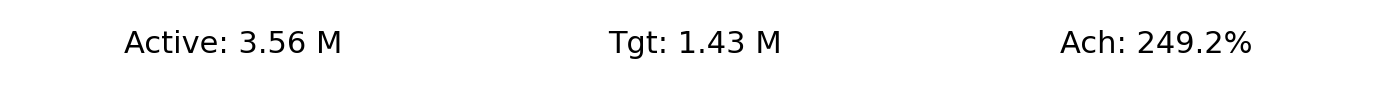

In [62]:
''' YTD Active Subs '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
# ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Active: {format(unit_mb(ytd_actv_sub),',.2f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(ytd_tgt_actv_sub),',.2f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(ytd_achv_actv_sub,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

# ax4.text(0.5, 0.5, f"YoY: {format(ytd_yoy_actv_sub,',.1%')}", size=22, ha='center', va='center')
# ax4.spines[['top','left','right','bottom']].set_visible(False)
# ax4.set_axis_off()

fig.tight_layout()
plt.show()

## ** Monthly **

### MTH : Aggregation

In [63]:
''' Create Dataframe '''

df_agg_s_mth = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_MTH', 'MTH_DESC', 'AGG_TYPE']).agg({'ACT': 'sum', 'TGT': 'sum'}).reset_index()
df_agg_n_mth = df_agg_n.loc[df_agg_n.groupby('TM_KEY_MTH')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_MTH', 'MTH_DESC', 'AGG_TYPE', 'ACT', 'TGT']]
df_rev_mth = pd.concat([df_agg_s_mth, df_agg_n_mth])

''' Aggregation '''
df_rev_mth['%ACHV'] = np.where(df_rev_mth['METRIC_NAME']=='TVS Churn Subs', -((df_rev_mth['ACT']/df_rev_mth['TGT'])-1), df_rev_mth['ACT']/df_rev_mth['TGT'])
df_rev_mth['GAP'] = df_rev_mth['ACT'] - df_rev_mth['TGT']
df_rev_mth['LAST_ACT'] = df_rev_mth.groupby('METRIC_CD')['ACT'].shift()
df_rev_mth['DIFF'] = df_rev_mth['ACT'] - df_rev_mth['LAST_ACT']
df_rev_mth['%MOM'] = (df_rev_mth['ACT'] / df_rev_mth['LAST_ACT']) - 1

df_rev_mth.tail(3)

,METRIC_CD,METRIC_NAME,TM_KEY_MTH,MTH_DESC,AGG_TYPE,ACT,TGT,%ACHV,GAP,LAST_ACT,DIFF,%MOM
58984,TB4S000500,TVS Active Subs,202304,April,N,3606936.0,1444764.0,2.496557,2162172.0,3630425.0,-23489.0,-0.006470
59015,TB4S000500,TVS Active Subs,202305,May,N,2460.0,1436888.0,0.001712,-1434428.0,3606936.0,-3604476.0,-0.999318
59042,TB4S000500,TVS Active Subs,202306,June,N,3563729.0,1429901.3,2.492290,2133827.7,2460.0,3561269.0,1447.670325


In [64]:
''' Pivot by KPIS '''

df_rev_mth_agg = df_rev_mth.pivot(index=['TM_KEY_MTH', 'MTH_DESC'], columns='METRIC_NAME', 
                                  values=['ACT', 'TGT', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%MOM']).rename(columns=cols_dict).reset_index()
df_rev_mth_agg.tail(3)

TM_KEY_MTH MTH_DESC        ACT                                 \
METRIC_NAME                       ACTV_SUB CHRN_SUB         EXIST NET_ADD   
1               202304    April  3606936.0      0.0  2.621890e+08     0.0   
2               202305      May     2460.0      0.0  3.606973e+08     0.0   
3               202306     June  3563729.0      0.0  2.038978e+08     0.0   

                                                           ...     %MOM  \
METRIC_NAME          NEW NEW_SUB NEW_SUB_MID NEW_SUB_PREM  ... CHRN_SUB   
1            11506348.65  5712.0       843.0        922.0  ...      NaN   
2            15522602.23  5886.0       907.0        906.0  ...      NaN   
3            14863410.08  7141.0       876.0        915.0  ...      NaN   

                                                                            \
METRIC_NAME     EXIST NET_ADD       NEW   NEW_SUB NEW_SUB_MID NEW_SUB_PREM   
1           -0.004447     NaN  0.247615 -0.108614   -0.083696    -0.324047   
2            0.375715     NaN  0.349047  0.030462    0.075919    -0.017354   
3           -0.434712     NaN -0.042467  0.213218   -0.034179     0.009934   

                                                
METRIC_NAME NEW_SUB_MASS NEW_SUB_NOW     TOTAL  
1              -0.042919   -0.233662  0.005756  
2               0.031923   -0.074766  0.374594  
3               0.313528    0.307449 -0.418529  

[3 rows x 79 columns]

In [65]:
''' MTD Values '''

day_cnt_curr_mth = len(df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==curr_mth]['TM_KEY_DAY'].unique())
day_cnt_last_mth = len(df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==last_mth]['TM_KEY_DAY'].unique())

''' Last Period : Values '''
last_mth_rev = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==last_mth]['ACT']['TOTAL'].sum()
last_mth_rev_new = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==last_mth]['ACT']['NEW'].sum()
last_mth_rev_exist = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==last_mth]['ACT']['EXIST'].sum()
last_mth_actv_sub = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==last_mth]['ACT']['ACTV_SUB'].sum()
last_mth_chrn_sub = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==last_mth]['ACT']['CHRN_SUB'].sum()
last_mth_net_add = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==last_mth]['ACT']['NET_ADD'].sum()
last_mth_new_sub = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==last_mth]['ACT']['NEW_SUB'].sum()
last_mth_new_sub_prem = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==last_mth]['ACT']['NEW_SUB_PREM'].sum()
last_mth_new_sub_mid = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==last_mth]['ACT']['NEW_SUB_MID'].sum()
last_mth_new_sub_mass = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==last_mth]['ACT']['NEW_SUB_MASS'].sum()
last_mth_new_sub_now = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==last_mth]['ACT']['NEW_SUB_NOW'].sum()

''' TOTAL : Values '''
mtd_rev = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==curr_mth]['ACT']['TOTAL'].sum()
mtd_tgt = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==curr_mth]['TGT']['TOTAL'].sum()
mtd_achv = mtd_rev / mtd_tgt
mtd_last_rev = (last_mth_rev / day_cnt_last_mth) * day_cnt_curr_mth
mtd_mom = (mtd_rev / mtd_last_rev) - 1
mtd_gap = mtd_rev - mtd_last_rev

''' NEW : Values '''
mtd_rev_new = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==curr_mth]['ACT']['NEW'].sum()
mtd_tgt_new = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==curr_mth]['TGT']['NEW'].sum()
mtd_achv_new = mtd_rev_new / mtd_tgt_new
mtd_last_rev_new = (last_mth_rev_new / day_cnt_last_mth) * day_cnt_curr_mth
mtd_mom_new = (mtd_rev_new / mtd_last_rev_new) - 1
mtd_gap_new = mtd_rev_new - mtd_last_rev_new

''' EXIST : Values '''
mtd_rev_exist = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==curr_mth]['ACT']['EXIST'].sum()
mtd_tgt_exist = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==curr_mth]['TGT']['EXIST'].sum()
mtd_achv_exist = mtd_rev_exist / mtd_tgt_exist
mtd_last_rev_exist = (last_mth_rev_exist / day_cnt_last_mth) * day_cnt_curr_mth
mtd_mom_exist = (mtd_rev_exist / mtd_last_rev_exist) - 1
mtd_gap_exist = mtd_rev_exist - mtd_last_rev_exist

''' ACTV_SUB : Values '''
mtd_actv_sub = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==curr_mth]['ACT']['ACTV_SUB'].sum()
mtd_tgt_actv_sub = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==curr_mth]['TGT']['ACTV_SUB'].sum()
mtd_achv_actv_sub = mtd_actv_sub / mtd_tgt_actv_sub
mtd_last_actv_sub = (last_mth_actv_sub / day_cnt_last_mth) * day_cnt_curr_mth
mtd_mom_actv_sub = (mtd_actv_sub / mtd_last_actv_sub) - 1
mtd_gap_actv_sub = mtd_actv_sub - mtd_last_actv_sub

''' CHRN_SUB : Values '''
mtd_chrn_sub = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==curr_mth]['ACT']['CHRN_SUB'].sum()
mtd_tgt_chrn_sub = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==curr_mth]['TGT']['CHRN_SUB'].sum()
mtd_achv_chrn_sub = -((mtd_chrn_sub / mtd_tgt_chrn_sub) - 1)
mtd_last_chrn_sub = (last_mth_chrn_sub / day_cnt_last_mth) * day_cnt_curr_mth
mtd_mom_chrn_sub = (mtd_chrn_sub / mtd_last_chrn_sub) - 1
mtd_gap_chrn_sub = mtd_chrn_sub - mtd_last_chrn_sub

''' NET_ADD : Values '''
mtd_net_add = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==curr_mth]['ACT']['NET_ADD'].sum()
mtd_tgt_net_add = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==curr_mth]['TGT']['NET_ADD'].sum()
mtd_achv_net_add = mtd_net_add / mtd_tgt_net_add
mtd_last_net_add = (last_mth_net_add / day_cnt_last_mth) * day_cnt_curr_mth
mtd_mom_net_add = (mtd_net_add / mtd_last_net_add) - 1
mtd_gap_net_add = mtd_net_add - mtd_last_net_add

''' NEW_SUB : Values '''
mtd_new_sub = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==curr_mth]['ACT']['NEW_SUB'].sum()
mtd_tgt_new_sub = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==curr_mth]['TGT']['NEW_SUB'].sum()
mtd_achv_new_sub = mtd_new_sub / mtd_tgt_new_sub
mtd_last_new_sub = (last_mth_new_sub / day_cnt_last_mth) * day_cnt_curr_mth
mtd_mom_new_sub = (mtd_new_sub / mtd_last_new_sub) - 1
mtd_gap_new_sub = mtd_new_sub - mtd_last_new_sub

''' NEW_SUB_PREM : Values '''
mtd_new_sub_prem = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==curr_mth]['ACT']['NEW_SUB_PREM'].sum()
mtd_tgt_new_sub_prem = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==curr_mth]['TGT']['NEW_SUB_PREM'].sum()
mtd_achv_new_sub_prem = mtd_new_sub_prem / mtd_tgt_new_sub_prem
mtd_last_new_sub_prem = (last_mth_new_sub_prem / day_cnt_last_mth) * day_cnt_curr_mth
mtd_mom_new_sub_prem = (mtd_new_sub_prem / mtd_last_new_sub_prem) - 1
mtd_gap_new_sub_prem = mtd_new_sub_prem - mtd_last_new_sub_prem

''' NEW_SUB_MID : Values '''
mtd_new_sub_mid = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==curr_mth]['ACT']['NEW_SUB_MID'].sum()
mtd_tgt_new_sub_mid = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==curr_mth]['TGT']['NEW_SUB_MID'].sum()
mtd_achv_new_sub_mid = mtd_new_sub_mid / mtd_tgt_new_sub_mid
mtd_last_new_sub_mid = (last_mth_new_sub_mid / day_cnt_last_mth) * day_cnt_curr_mth
mtd_mom_new_sub_mid = (mtd_new_sub_mid / mtd_last_new_sub_mid) - 1
mtd_gap_new_sub_mid = mtd_new_sub_mid - mtd_last_new_sub_mid

''' NEW_SUB_MASS : Values '''
mtd_new_sub_mass = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==curr_mth]['ACT']['NEW_SUB_MASS'].sum()
mtd_tgt_new_sub_mass = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==curr_mth]['TGT']['NEW_SUB_MASS'].sum()
mtd_achv_new_sub_mass = mtd_new_sub_mass / mtd_tgt_new_sub_mass
mtd_last_new_sub_mass = (last_mth_new_sub_mass / day_cnt_last_mth) * day_cnt_curr_mth
mtd_mom_new_sub_mass = (mtd_new_sub_mass / mtd_last_new_sub_mass) - 1
mtd_gap_new_sub_mass = mtd_new_sub_mass - mtd_last_new_sub_mass

''' NEW_SUB_NOW : Values '''
mtd_new_sub_now = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==curr_mth]['ACT']['NEW_SUB_NOW'].sum()
mtd_tgt_new_sub_now = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==curr_mth]['TGT']['NEW_SUB_NOW'].sum()
mtd_achv_new_sub_now = mtd_new_sub_now / mtd_tgt_new_sub_now
mtd_last_new_sub_now = (last_mth_new_sub_now / day_cnt_last_mth) * day_cnt_curr_mth
mtd_mom_new_sub_now = (mtd_new_sub_now / mtd_last_new_sub_now) - 1
mtd_gap_new_sub_now = mtd_new_sub_now - mtd_last_new_sub_now

C:\Users\Narut4\AppData\Local\Temp\ipykernel_10600\3625918861.py:54: RuntimeWarning: invalid value encountered in scalar divide
  mtd_achv_chrn_sub = -((mtd_chrn_sub / mtd_tgt_chrn_sub) - 1)
C:\Users\Narut4\AppData\Local\Temp\ipykernel_10600\3625918861.py:56: RuntimeWarning: invalid value encountered in scalar divide
  mtd_mom_chrn_sub = (mtd_chrn_sub / mtd_last_chrn_sub) - 1
C:\Users\Narut4\AppData\Local\Temp\ipykernel_10600\3625918861.py:62: RuntimeWarning: invalid value encountered in scalar divide
  mtd_achv_net_add = mtd_net_add / mtd_tgt_net_add
C:\Users\Narut4\AppData\Local\Temp\ipykernel_10600\3625918861.py:64: RuntimeWarning: invalid value encountered in scalar divide
  mtd_mom_net_add = (mtd_net_add / mtd_last_net_add) - 1
C:\Users\Narut4\AppData\Local\Temp\ipykernel_10600\3625918861.py:78: RuntimeWarning: divide by zero encountered in scalar divide
  mtd_achv_new_sub_prem = mtd_new_sub_prem / mtd_tgt_new_sub_prem
C:\Users\Narut4\AppData\Local\Temp\ipykernel_10600\3625918861.

In [66]:
''' MTD BarH Dataframe'''

df_bar_h_mtd = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==curr_mth]['ACT'][['NEW_SUB', 'NEW_SUB_NOW', 'CHRN_SUB', 'NET_ADD']].T.reset_index()
df_bar_h_mtd.columns = ['METRIC_NAME', 'VALUES']

color_conditions = [df_bar_h_mtd['METRIC_NAME']=='NEW_SUB', 
                    df_bar_h_mtd['METRIC_NAME']=='NEW_SUB_NOW', 
                    df_bar_h_mtd['METRIC_NAME']=='CHRN_SUB', 
                    df_bar_h_mtd['METRIC_NAME']=='NET_ADD',]
color_results = ['limegreen', 'turquoise', 'lightcoral', 'gold']
sort_results = [1, 2, 3, 4]

df_bar_h_mtd['COLOR'] = np.select(color_conditions, color_results)
df_bar_h_mtd['SORT_NO'] = np.select(color_conditions, sort_results)

df_bar_h_mtd = df_bar_h_mtd.sort_values(by='SORT_NO', ascending=False)
df_bar_h_mtd

,METRIC_NAME,VALUES,COLOR,SORT_NO
3,NET_ADD,0.0,gold,4
2,CHRN_SUB,0.0,lightcoral,3
1,NEW_SUB_NOW,2071.0,turquoise,2
0,NEW_SUB,7141.0,limegreen,1


In [67]:
''' Month Chart Values '''

x_mth = df_rev_mth_agg['MTH_DESC']
x_mth_axis = np.arange(len(x_mth))

''' TOTAL : Values '''
y_mth_act = df_rev_mth_agg['ACT']['TOTAL']
y_mth_tgt = df_rev_mth_agg['TGT']['TOTAL']
y_mth_achv = df_rev_mth_agg['%ACHV']['TOTAL']
y_mth_gap = df_rev_mth_agg['GAP']['TOTAL']
y_mth_diff = df_rev_mth_agg['DIFF']['TOTAL']
y_mth_last_act = df_rev_mth_agg['LAST_ACT']['TOTAL']
y_mth_mom = df_rev_mth_agg['%MOM']['TOTAL']

''' NEW : Values '''
y_mth_act_new = df_rev_mth_agg['ACT']['NEW']
y_mth_tgt_new = df_rev_mth_agg['TGT']['NEW']
y_mth_achv_new = df_rev_mth_agg['%ACHV']['NEW']
y_mth_gap_new = df_rev_mth_agg['GAP']['NEW']
y_mth_diff_new = df_rev_mth_agg['DIFF']['NEW']
y_mth_last_act_new = df_rev_mth_agg['LAST_ACT']['NEW']
y_mth_mom_new = df_rev_mth_agg['%MOM']['NEW']

''' EXIST : Values '''
y_mth_act_exist = df_rev_mth_agg['ACT']['EXIST']
y_mth_tgt_exist = df_rev_mth_agg['TGT']['EXIST']
y_mth_achv_exist = df_rev_mth_agg['%ACHV']['EXIST']
y_mth_gap_exist = df_rev_mth_agg['GAP']['EXIST']
y_mth_diff_exist = df_rev_mth_agg['DIFF']['EXIST']
y_mth_last_act_exist = df_rev_mth_agg['LAST_ACT']['EXIST']
y_mth_mom_exist = df_rev_mth_agg['%MOM']['EXIST']

''' ACTV_SUB : Values '''
y_mth_act_actv_sub = df_rev_mth_agg['ACT']['ACTV_SUB']
y_mth_tgt_actv_sub = df_rev_mth_agg['TGT']['ACTV_SUB']
y_mth_achv_actv_sub = df_rev_mth_agg['%ACHV']['ACTV_SUB']
y_mth_gap_actv_sub = df_rev_mth_agg['GAP']['ACTV_SUB']
y_mth_diff_actv_sub = df_rev_mth_agg['DIFF']['ACTV_SUB']
y_mth_last_act_actv_sub = df_rev_mth_agg['LAST_ACT']['ACTV_SUB']
y_mth_mom_actv_sub = df_rev_mth_agg['%MOM']['ACTV_SUB']

''' CHRN_SUB : Values '''
y_mth_act_chrn_sub = df_rev_mth_agg['ACT']['CHRN_SUB']
y_mth_tgt_chrn_sub = df_rev_mth_agg['TGT']['CHRN_SUB']
y_mth_achv_chrn_sub = df_rev_mth_agg['%ACHV']['CHRN_SUB']
y_mth_gap_chrn_sub = df_rev_mth_agg['GAP']['CHRN_SUB']
y_mth_diff_chrn_sub = df_rev_mth_agg['DIFF']['CHRN_SUB']
y_mth_last_act_chrn_sub = df_rev_mth_agg['LAST_ACT']['CHRN_SUB']
y_mth_mom_chrn_sub = df_rev_mth_agg['%MOM']['CHRN_SUB']

''' NET_ADD : Values '''
y_mth_act_net_add = df_rev_mth_agg['ACT']['NET_ADD']
y_mth_tgt_net_add = df_rev_mth_agg['TGT']['NET_ADD']
y_mth_achv_net_add = df_rev_mth_agg['%ACHV']['NET_ADD']
y_mth_gap_net_add = df_rev_mth_agg['GAP']['NET_ADD']
y_mth_diff_net_add = df_rev_mth_agg['DIFF']['NET_ADD']
y_mth_last_act_net_add = df_rev_mth_agg['LAST_ACT']['NET_ADD']
y_mth_mom_net_add = df_rev_mth_agg['%MOM']['NET_ADD']

''' NEW_SUB : Values '''
y_mth_act_new_sub = df_rev_mth_agg['ACT']['NEW_SUB']
y_mth_tgt_new_sub = df_rev_mth_agg['TGT']['NEW_SUB']
y_mth_achv_new_sub = df_rev_mth_agg['%ACHV']['NEW_SUB']
y_mth_gap_new_sub = df_rev_mth_agg['GAP']['NEW_SUB']
y_mth_diff_new_sub = df_rev_mth_agg['DIFF']['NEW_SUB']
y_mth_last_act_new_sub = df_rev_mth_agg['LAST_ACT']['NEW_SUB']
y_mth_mom_new_sub = df_rev_mth_agg['%MOM']['NEW_SUB']

''' NEW_SUB_PREM : Values '''
y_mth_act_new_sub_prem = df_rev_mth_agg['ACT']['NEW_SUB_PREM']
y_mth_tgt_new_sub_prem = df_rev_mth_agg['TGT']['NEW_SUB_PREM']
y_mth_achv_new_sub_prem = df_rev_mth_agg['%ACHV']['NEW_SUB_PREM']
y_mth_gap_new_sub_prem = df_rev_mth_agg['GAP']['NEW_SUB_PREM']
y_mth_diff_new_sub_prem = df_rev_mth_agg['DIFF']['NEW_SUB_PREM']
y_mth_last_act_new_sub_prem = df_rev_mth_agg['LAST_ACT']['NEW_SUB_PREM']
y_mth_mom_new_sub_prem = df_rev_mth_agg['%MOM']['NEW_SUB_PREM']

''' NEW_SUB_MID : Values '''
y_mth_act_new_sub_mid = df_rev_mth_agg['ACT']['NEW_SUB_MID']
y_mth_tgt_new_sub_mid = df_rev_mth_agg['TGT']['NEW_SUB_MID']
y_mth_achv_new_sub_mid = df_rev_mth_agg['%ACHV']['NEW_SUB_MID']
y_mth_gap_new_sub_mid = df_rev_mth_agg['GAP']['NEW_SUB_MID']
y_mth_diff_new_sub_mid = df_rev_mth_agg['DIFF']['NEW_SUB_MID']
y_mth_last_act_new_sub_mid = df_rev_mth_agg['LAST_ACT']['NEW_SUB_MID']
y_mth_mom_new_sub_mid = df_rev_mth_agg['%MOM']['NEW_SUB_MID']

''' NEW_SUB_MASS : Values '''
y_mth_act_new_sub_mass = df_rev_mth_agg['ACT']['NEW_SUB_MASS']
y_mth_tgt_new_sub_mass = df_rev_mth_agg['TGT']['NEW_SUB_MASS']
y_mth_achv_new_sub_mass = df_rev_mth_agg['%ACHV']['NEW_SUB_MASS']
y_mth_gap_new_sub_mass = df_rev_mth_agg['GAP']['NEW_SUB_MASS']
y_mth_diff_new_sub_mass = df_rev_mth_agg['DIFF']['NEW_SUB_MASS']
y_mth_last_act_new_sub_mass = df_rev_mth_agg['LAST_ACT']['NEW_SUB_MASS']
y_mth_mom_new_sub_mass = df_rev_mth_agg['%MOM']['NEW_SUB_MASS']

''' NEW_SUB_NOW : Values '''
y_mth_act_new_sub_now = df_rev_mth_agg['ACT']['NEW_SUB_NOW']
y_mth_tgt_new_sub_now = df_rev_mth_agg['TGT']['NEW_SUB_NOW']
y_mth_achv_new_sub_now = df_rev_mth_agg['%ACHV']['NEW_SUB_NOW']
y_mth_gap_new_sub_now = df_rev_mth_agg['GAP']['NEW_SUB_NOW']
y_mth_diff_new_sub_now = df_rev_mth_agg['DIFF']['NEW_SUB_NOW']
y_mth_last_act_new_sub_now = df_rev_mth_agg['LAST_ACT']['NEW_SUB_NOW']
y_mth_mom_new_sub_now = df_rev_mth_agg['%MOM']['NEW_SUB_NOW']

### MTH : Visualizations

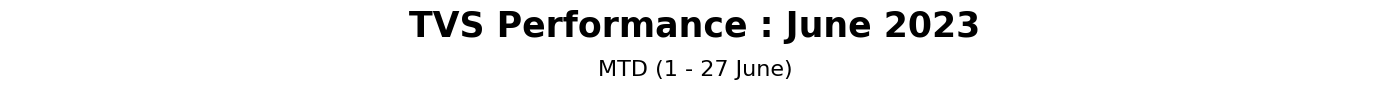

In [68]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

ax1.text(0.5, 0.5, f"TVS Performance : {curr_mth_desc} {curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"MTD (1 - {curr_day_label} {curr_mth_desc})", size=16, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

fig.tight_layout()
plt.show()

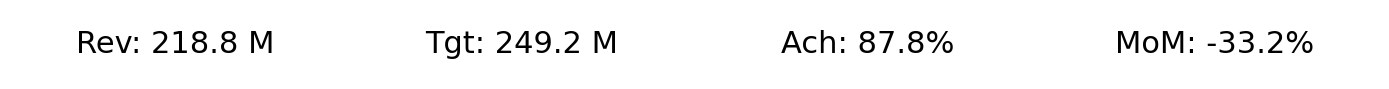

In [69]:
''' MTD Revenue '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Rev: {format(unit_mb(mtd_rev),',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(mtd_tgt),',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(mtd_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"MoM: {format(mtd_mom,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

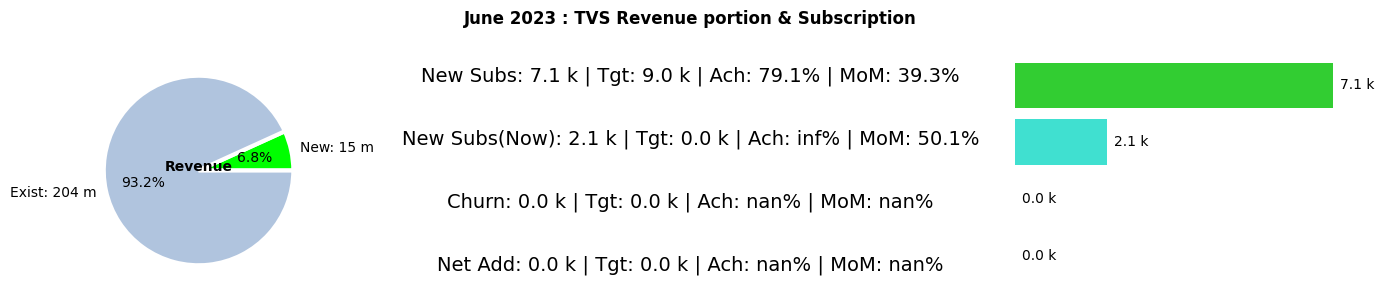

In [70]:
'''' Revenue Portion & Subscription '''

fig = plt.figure(figsize=(14, 3))
fig.suptitle(f'{curr_mth_desc} {curr_yr} : TVS Revenue portion & Subscription', weight='bold')
gs = GridSpec(4, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[2, 1])
ax5 = fig.add_subplot(gs[3, 1])
ax6 = fig.add_subplot(gs[:, 2])

''' ax1 '''
y = np.array([unit_mb(mtd_rev_new.sum()), unit_mb(mtd_rev_exist.sum())])
mylabels = [f"New: {format(y[0],',.0f')} m", f"Exist: {format(y[1],',.0f')} m"]
mycolors = ["lime", "lightsteelblue"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 3, "edgecolor": "white"})
ax1.text(0, 0, 'Revenue', ha='center', fontsize=10, weight='bold')

''' ax2 '''
ax2.text(0.5, 0.5, 
         f"New Subs: {format(unit_k(mtd_new_sub),',.1f')} k | Tgt: {format(unit_k(mtd_tgt_new_sub),',.1f')} k | Ach: {format(mtd_achv_new_sub,',.1%')} | MoM: {format(mtd_mom_new_sub,',.1%')}", 
         size=14, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

''' ax3 '''
ax3.text(0.5, 0.5, 
         f"New Subs(Now): {format(unit_k(mtd_new_sub_now),',.1f')} k | Tgt: {format(unit_k(mtd_tgt_new_sub_now),',.1f')} k | Ach: {format(mtd_achv_new_sub_now,',.1%')} | MoM: {format(mtd_mom_new_sub_now,',.1%')}", 
         size=14, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

''' ax4 '''
ax4.text(0.5, 0.5, 
         f"Churn: {format(unit_k(mtd_chrn_sub),',.1f')} k | Tgt: {format(unit_k(mtd_tgt_chrn_sub),',.1f')} k | Ach: {format(mtd_achv_chrn_sub,',.1%')} | MoM: {format(mtd_mom_chrn_sub,',.1%')}", 
         size=14, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

''' ax5 '''
ax5.text(0.5, 0.5, 
         f"Net Add: {format(unit_k(mtd_net_add),',.1f')} k | Tgt: {format(unit_k(mtd_tgt_net_add),',.1f')} k | Ach: {format(mtd_achv_net_add,',.1%')} | MoM: {format(mtd_mom_net_add,',.1%')}", 
         size=14, ha='center', va='center')
ax5.spines[['top','left','right','bottom']].set_visible(False)
ax5.set_axis_off()

''' ax6 '''
bars = ax6.barh(df_bar_h_mtd['METRIC_NAME'], width=unit_k(df_bar_h_mtd['VALUES']), color=df_bar_h_mtd['COLOR'])
ax6.bar_label(bars, padding=5, fmt='%.1f k')
ax6.spines[['top','left','right','bottom']].set_visible(False)
ax6 = plt.gca()
ax6.get_xaxis().set_visible(False)
ax6.get_yaxis().set_visible(False)

fig.tight_layout()
plt.show()

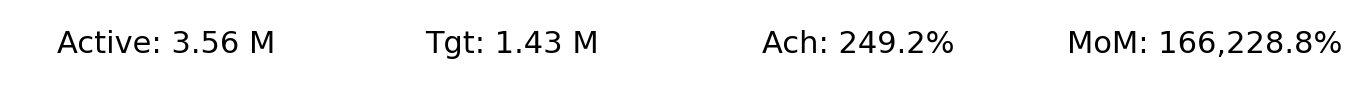

In [71]:
''' MTD Active Subs '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Active: {format(unit_mb(mtd_actv_sub),',.2f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(mtd_tgt_actv_sub),',.2f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(mtd_achv_actv_sub,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"MoM: {format(mtd_mom_actv_sub,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

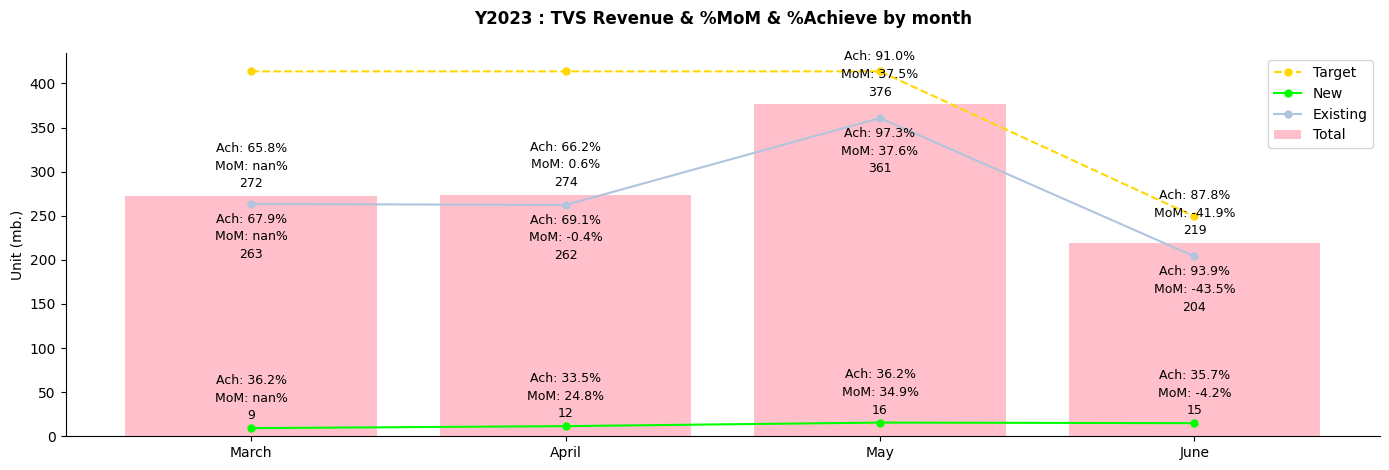

In [72]:
''' Revenue & MoM & Achieve by month '''

plt.figure().set_figwidth(14)
plt.title(f"Y{curr_yr} : TVS Revenue & %MoM & %Achieve by month\n", weight='bold')

plt.bar(x_mth_axis, unit_mb(y_mth_act), label='Total', color='pink')

plt.plot(x_mth_axis, unit_mb(y_mth_tgt), marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
plt.plot(x_mth_axis, unit_mb(y_mth_act_new), marker='.', markeredgewidth=3, label='New', color='lime')
plt.plot(x_mth_axis, unit_mb(y_mth_act_exist), marker='.', markeredgewidth=3, label='Existing', color='lightsteelblue')

for i in x_mth_axis:
    plt.annotate(f"Ach: {format(y_mth_achv[i],',.1%')}", xy=(x_mth_axis[i], unit_mb(y_mth_act[i])+50), ha='center', fontsize=9)
    plt.annotate(f"MoM: {format(y_mth_mom[i],',.1%')}", xy=(x_mth_axis[i], unit_mb(y_mth_act[i])+30), ha='center', fontsize=9)
    plt.annotate(format(unit_mb(y_mth_act[i]),',.0f'), xy=(x_mth_axis[i], unit_mb(y_mth_act[i])+10), ha='center', fontsize=9)

    plt.annotate(f"Ach: {format(y_mth_achv_new[i],',.1%')}", xy=(x_mth_axis[i], unit_mb(y_mth_act_new[i])+50), ha='center', fontsize=9)
    plt.annotate(f"MoM: {format(y_mth_mom_new[i],',.1%')}", xy=(x_mth_axis[i], unit_mb(y_mth_act_new[i])+30), ha='center', fontsize=9)
    plt.annotate(format(unit_mb(y_mth_act_new[i]),',.0f'), xy=(x_mth_axis[i], unit_mb(y_mth_act_new[i])+10), ha='center', fontsize=9)
    
    plt.annotate(f"Ach: {format(y_mth_achv_exist[i],',.1%')}", xy=(x_mth_axis[i], unit_mb(y_mth_act_exist[i])-10), ha='center', va='top', fontsize=9)
    plt.annotate(f"MoM: {format(y_mth_mom_exist[i],',.1%')}", xy=(x_mth_axis[i], unit_mb(y_mth_act_exist[i])-30), ha='center', va='top', fontsize=9)
    plt.annotate(format(unit_mb(y_mth_act_exist[i]),',.0f'), xy=(x_mth_axis[i], unit_mb(y_mth_act_exist[i])-50), ha='center', va='top', fontsize=9)

plt.ylabel('Unit (mb.)')
plt.xticks(x_mth_axis, x_mth)
plt.legend()
plt.tight_layout()
plt.show()

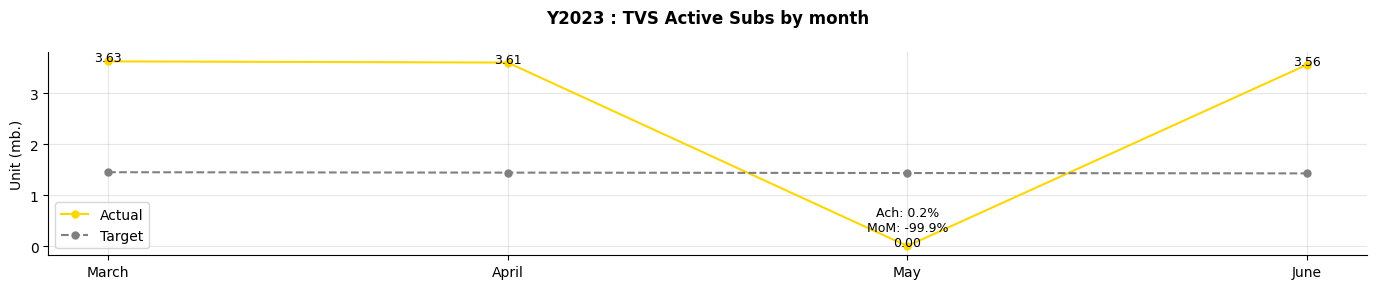

In [73]:
''' Active Subs by month '''

plt.figure(figsize=(14, 3))
plt.title(f"Y{curr_yr} : TVS Active Subs by month\n", weight='bold')

plt.plot(x_mth_axis, unit_mb(y_mth_act_actv_sub), marker='.', markeredgewidth=3, label='Actual', color='gold')
plt.plot(x_mth_axis, unit_mb(y_mth_tgt_actv_sub), marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='grey')
for i in x_mth_axis:
    plt.annotate(f"Ach: {format(y_mth_achv_actv_sub[i],',.1%')}", xy=(x_mth_axis[i], unit_mb(y_mth_act_actv_sub[i])+0.6), ha='center', fontsize=9)
    plt.annotate(f"MoM: {format(y_mth_mom_actv_sub[i],',.1%')}", xy=(x_mth_axis[i], unit_mb(y_mth_act_actv_sub[i])+0.3), ha='center', fontsize=9)
    plt.annotate(format(unit_mb(y_mth_act_actv_sub[i]),',.2f'), xy=(x_mth_axis[i], unit_mb(y_mth_act_actv_sub[i])), ha='center', fontsize=9)

plt.ylabel('Unit (mb.)')
plt.xticks(x_mth_axis, x_mth)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

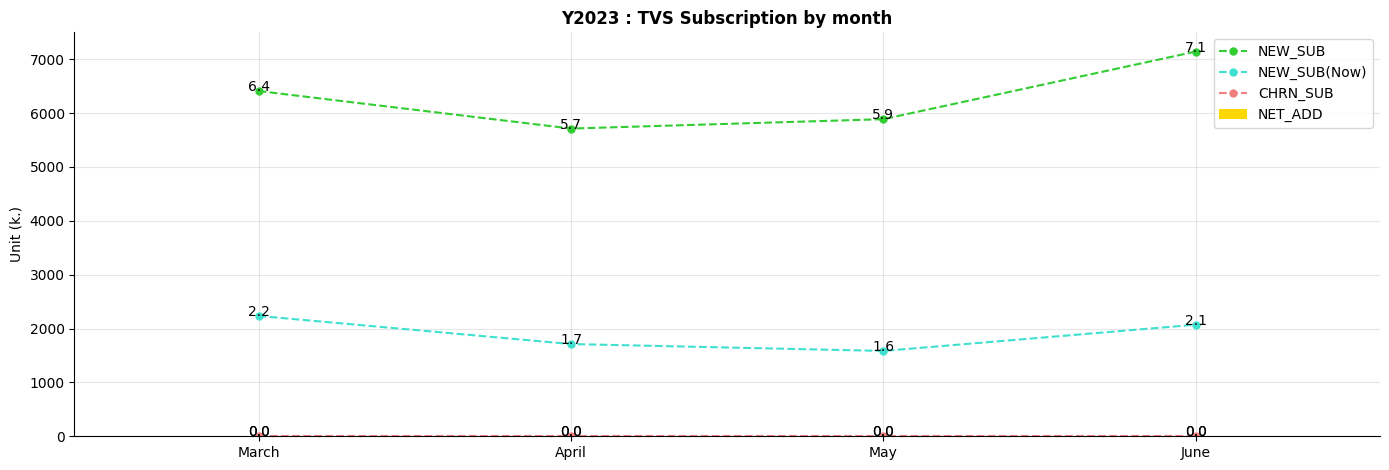

In [74]:
''' Subscription by month '''

plt.figure().set_figwidth(14)
plt.title(f"Y{curr_yr} : TVS Subscription by month", weight='bold')

plt.plot(x_mth_axis, y_mth_act_new_sub, marker='.', linestyle='dashed', markeredgewidth=3, label='NEW_SUB', color='limegreen')
plt.plot(x_mth_axis, y_mth_act_new_sub_now, marker='.', linestyle='dashed', markeredgewidth=3, label='NEW_SUB(Now)', color='turquoise')
plt.plot(x_mth_axis, y_mth_act_chrn_sub, marker='.', linestyle='dashed', markeredgewidth=3, label='CHRN_SUB', color='lightcoral')
plt.bar(x_mth_axis, y_mth_act_net_add, label='NET_ADD', color='gold')
for i in x_mth_axis:
    plt.annotate(format(unit_k(y_mth_act_new_sub[i]),',.1f'), xy=(x_mth_axis[i], y_mth_act_new_sub[i]), ha='center')
    plt.annotate(format(unit_k(y_mth_act_new_sub_now[i]),',.1f'), xy=(x_mth_axis[i], y_mth_act_new_sub_now[i]), ha='center')
    plt.annotate(format(unit_k(y_mth_act_chrn_sub[i]),',.1f'), xy=(x_mth_axis[i], y_mth_act_chrn_sub[i]), ha='center')
    plt.annotate(format(unit_k(y_mth_act_net_add[i]),',.1f'), xy=(x_mth_axis[i], y_mth_act_net_add[i]), ha='center')

plt.ylabel('Unit (k.)')
plt.xticks(x_mth_axis, x_mth)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## ** Weekly **

### WK : Aggregation

In [75]:
''' Create Dataframe '''

df_agg_s_wk = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_WK', 'WK_LABEL', 'AGG_TYPE']).agg({'ACT': 'sum', 'TGT': 'sum'}).reset_index()
df_agg_n_wk = df_agg_n.loc[df_agg_n.groupby('TM_KEY_WK')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_WK', 'WK_LABEL', 'AGG_TYPE', 'ACT', 'TGT']]
df_rev_wk = pd.concat([df_agg_s_wk, df_agg_n_wk])

''' Aggregation '''
df_rev_wk['%ACHV'] = np.where(df_rev_wk['METRIC_NAME']=='TVS Churn Subs', -((df_rev_wk['ACT']/df_rev_wk['TGT'])-1), df_rev_wk['ACT']/df_rev_wk['TGT'])
df_rev_wk['GAP'] = df_rev_wk['ACT'] - df_rev_wk['TGT']
df_rev_wk['LAST_ACT'] = df_rev_wk.groupby('METRIC_CD')['ACT'].shift()
df_rev_wk['DIFF'] = df_rev_wk['ACT'] - df_rev_wk['LAST_ACT']
df_rev_wk['%WOW'] = (df_rev_wk['ACT'] / df_rev_wk['LAST_ACT']) - 1

df_rev_wk.tail(3)

,METRIC_CD,METRIC_NAME,TM_KEY_WK,WK_LABEL,AGG_TYPE,ACT,TGT,%ACHV,GAP,LAST_ACT,DIFF,%WOW
59033,TB4S000500,TVS Active Subs,2023024,24,N,3568306.0,1.432230e+06,2.491433,2.136076e+06,3577328.0,-9022.0,-0.002522
59040,TB4S000500,TVS Active Subs,2023025,25,N,3562101.0,1.430419e+06,2.490250,2.131682e+06,3568306.0,-6205.0,-0.001739
59042,TB4S000500,TVS Active Subs,2023026,26,N,3563729.0,1.429901e+06,2.492290,2.133828e+06,3562101.0,1628.0,0.000457


In [76]:
''' Pivot by KPIS '''

df_rev_wk_agg = df_rev_wk.pivot(index=['TM_KEY_WK', 'WK_LABEL'], columns='METRIC_NAME', 
                                values=['ACT', 'TGT', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%WOW']).rename(columns=cols_dict).reset_index()
df_rev_wk_agg.tail(3)

TM_KEY_WK WK_LABEL        ACT                                \
METRIC_NAME                      ACTV_SUB CHRN_SUB        EXIST NET_ADD   
15            2023024       24  3568306.0      0.0  51453149.38     0.0   
16            2023025       25  3562101.0      0.0  69897963.09     0.0   
17            2023026       26  3563729.0      0.0         0.00     0.0   

                                                          ...     %WOW  \
METRIC_NAME         NEW NEW_SUB NEW_SUB_MID NEW_SUB_PREM  ... CHRN_SUB   
15           3096916.89  1976.0       220.0        210.0  ...      NaN   
16           5355523.49  2193.0       236.0        256.0  ...      NaN   
17                 0.00   544.0        54.0        104.0  ...      NaN   

                                                                            \
METRIC_NAME     EXIST NET_ADD       NEW   NEW_SUB NEW_SUB_MID NEW_SUB_PREM   
15           0.196997     NaN -0.291097  0.235772    0.009174    -0.027778   
16           0.358478     NaN  0.729308  0.109818    0.072727     0.219048   
17          -1.000000     NaN -1.000000 -0.751938   -0.771186    -0.593750   

                                                
METRIC_NAME NEW_SUB_MASS NEW_SUB_NOW     TOTAL  
15              0.327039   -0.455446  0.151968  
16              0.100259   -0.418182  0.379525  
17             -0.773075   -0.930556 -1.000000  

[3 rows x 79 columns]

In [77]:
''' WTD Values '''

day_cnt_curr_wk = len(df_rev_day_agg[df_rev_day_agg['TM_KEY_WK']==curr_wk]['TM_KEY_DAY'].unique())
day_cnt_last_wk = len(df_rev_day_agg[df_rev_day_agg['TM_KEY_WK']==last_wk]['TM_KEY_DAY'].unique())

''' Last Period : Values '''
last_wk_rev = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==last_wk]['ACT']['TOTAL'].sum()
last_wk_rev_new = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==last_wk]['ACT']['NEW'].sum()
last_wk_rev_exist = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==last_wk]['ACT']['EXIST'].sum()
last_wk_actv_sub = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==last_wk]['ACT']['ACTV_SUB'].sum()
last_wk_chrn_sub = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==last_wk]['ACT']['CHRN_SUB'].sum()
last_wk_net_add = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==last_wk]['ACT']['NET_ADD'].sum()
last_wk_new_sub = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==last_wk]['ACT']['NEW_SUB'].sum()
last_wk_new_sub_prem = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==last_wk]['ACT']['NEW_SUB_PREM'].sum()
last_wk_new_sub_mid = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==last_wk]['ACT']['NEW_SUB_MID'].sum()
last_wk_new_sub_mass = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==last_wk]['ACT']['NEW_SUB_MASS'].sum()
last_wk_new_sub_now = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==last_wk]['ACT']['NEW_SUB_NOW'].sum()

''' TOTAL : Values '''
wtd_rev = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==curr_wk]['ACT']['TOTAL'].sum()
wtd_tgt = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==curr_wk]['TGT']['TOTAL'].sum()
wtd_achv = wtd_rev / wtd_tgt
wtd_last_rev = (last_wk_rev / day_cnt_last_wk) * day_cnt_curr_wk
wtd_wow = (wtd_rev / wtd_last_rev) - 1
wtd_gap = wtd_rev - wtd_last_rev

''' NEW : Values '''
wtd_rev_new = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==curr_wk]['ACT']['NEW'].sum()
wtd_tgt_new = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==curr_wk]['TGT']['NEW'].sum()
wtd_achv_new = wtd_rev_new / wtd_tgt_new
wtd_last_rev_new = (last_wk_rev_new / day_cnt_last_wk) * day_cnt_curr_wk
wtd_wow_new = (wtd_rev_new / wtd_last_rev_new) - 1
wtd_gap_new = wtd_rev_new - wtd_last_rev_new

''' EXIST : Values '''
wtd_rev_exist = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==curr_wk]['ACT']['EXIST'].sum()
wtd_tgt_exist = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==curr_wk]['TGT']['EXIST'].sum()
wtd_achv_exist = wtd_rev_exist / wtd_tgt_exist
wtd_last_rev_exist = (last_wk_rev_exist / day_cnt_last_wk) * day_cnt_curr_wk
wtd_wow_exist = (wtd_rev_exist / wtd_last_rev_exist) - 1
wtd_gap_exist = wtd_rev_exist - wtd_last_rev_exist

''' ACTV_SUB : Values '''
wtd_actv_sub = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==curr_wk]['ACT']['ACTV_SUB'].sum()
wtd_tgt_actv_sub = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==curr_wk]['TGT']['ACTV_SUB'].sum()
wtd_achv_actv_sub = wtd_actv_sub / wtd_tgt_actv_sub
wtd_last_actv_sub = (last_wk_actv_sub / day_cnt_last_wk) * day_cnt_curr_wk
wtd_wow_actv_sub = (wtd_actv_sub / wtd_last_actv_sub) - 1
wtd_gap_actv_sub = wtd_actv_sub - wtd_last_actv_sub

''' CHRN_SUB : Values '''
wtd_chrn_sub = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==curr_wk]['ACT']['CHRN_SUB'].sum()
wtd_tgt_chrn_sub = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==curr_wk]['TGT']['CHRN_SUB'].sum()
wtd_achv_chrn_sub = -((wtd_chrn_sub / wtd_tgt_chrn_sub) - 1)
wtd_last_chrn_sub = (last_wk_chrn_sub / day_cnt_last_wk) * day_cnt_curr_wk
wtd_wow_chrn_sub = (wtd_chrn_sub / wtd_last_chrn_sub) - 1
wtd_gap_chrn_sub = wtd_chrn_sub - wtd_last_chrn_sub

''' NET_ADD : Values '''
wtd_net_add = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==curr_wk]['ACT']['NET_ADD'].sum()
wtd_tgt_net_add = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==curr_wk]['TGT']['NET_ADD'].sum()
wtd_achv_net_add = wtd_net_add / wtd_tgt_net_add
wtd_last_net_add = (last_wk_net_add / day_cnt_last_wk) * day_cnt_curr_wk
wtd_wow_net_add = (wtd_net_add / wtd_last_net_add) - 1
wtd_gap_net_add = wtd_net_add - wtd_last_net_add

''' NEW_SUB : Values '''
wtd_new_sub = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==curr_wk]['ACT']['NEW_SUB'].sum()
wtd_tgt_new_sub = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==curr_wk]['TGT']['NEW_SUB'].sum()
wtd_achv_new_sub = wtd_new_sub / wtd_tgt_new_sub
wtd_last_new_sub = (last_wk_new_sub / day_cnt_last_wk) * day_cnt_curr_wk
wtd_wow_new_sub = (wtd_new_sub / wtd_last_new_sub) - 1
wtd_gap_new_sub = wtd_new_sub - wtd_last_new_sub

''' NEW_SUB_PREM : Values '''
wtd_new_sub_prem = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==curr_wk]['ACT']['NEW_SUB_PREM'].sum()
wtd_tgt_new_sub_prem = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==curr_wk]['TGT']['NEW_SUB_PREM'].sum()
wtd_achv_new_sub_prem = wtd_new_sub_prem / wtd_tgt_new_sub_prem
wtd_last_new_sub_prem = (last_wk_new_sub_prem / day_cnt_last_wk) * day_cnt_curr_wk
wtd_wow_new_sub_prem = (wtd_new_sub_prem / wtd_last_new_sub_prem) - 1
wtd_gap_new_sub_prem = wtd_new_sub_prem - wtd_last_new_sub_prem

''' NEW_SUB_MID : Values '''
wtd_new_sub_mid = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==curr_wk]['ACT']['NEW_SUB_MID'].sum()
wtd_tgt_new_sub_mid = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==curr_wk]['TGT']['NEW_SUB_MID'].sum()
wtd_achv_new_sub_mid = wtd_new_sub_mid / wtd_tgt_new_sub_mid
wtd_last_new_sub_mid = (last_wk_new_sub_mid / day_cnt_last_wk) * day_cnt_curr_wk
wtd_wow_new_sub_mid = (wtd_new_sub_mid / wtd_last_new_sub_mid) - 1
wtd_gap_new_sub_mid = wtd_new_sub_mid - wtd_last_new_sub_mid

''' NEW_SUB_MASS : Values '''
wtd_new_sub_mass = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==curr_wk]['ACT']['NEW_SUB_MASS'].sum()
wtd_tgt_new_sub_mass = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==curr_wk]['TGT']['NEW_SUB_MASS'].sum()
wtd_achv_new_sub_mass = wtd_new_sub_mass / wtd_tgt_new_sub_mass
wtd_last_new_sub_mass = (last_wk_new_sub_mass / day_cnt_last_wk) * day_cnt_curr_wk
wtd_wow_new_sub_mass = (wtd_new_sub_mass / wtd_last_new_sub_mass) - 1
wtd_gap_new_sub_mass = wtd_new_sub_mass - wtd_last_new_sub_mass

''' NEW_SUB_NOW : Values '''
wtd_new_sub_now = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==curr_wk]['ACT']['NEW_SUB_NOW'].sum()
wtd_tgt_new_sub_now = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==curr_wk]['TGT']['NEW_SUB_NOW'].sum()
wtd_achv_new_sub_now = wtd_new_sub_now / wtd_tgt_new_sub_now
wtd_last_new_sub_now = (last_wk_new_sub_now / day_cnt_last_wk) * day_cnt_curr_wk
wtd_wow_new_sub_now = (wtd_new_sub_now / wtd_last_new_sub_now) - 1
wtd_gap_new_sub_now = wtd_new_sub_now - wtd_last_new_sub_now

C:\Users\Narut4\AppData\Local\Temp\ipykernel_10600\390100672.py:22: RuntimeWarning: invalid value encountered in scalar divide
  wtd_achv = wtd_rev / wtd_tgt
C:\Users\Narut4\AppData\Local\Temp\ipykernel_10600\390100672.py:30: RuntimeWarning: invalid value encountered in scalar divide
  wtd_achv_new = wtd_rev_new / wtd_tgt_new
C:\Users\Narut4\AppData\Local\Temp\ipykernel_10600\390100672.py:38: RuntimeWarning: invalid value encountered in scalar divide
  wtd_achv_exist = wtd_rev_exist / wtd_tgt_exist
C:\Users\Narut4\AppData\Local\Temp\ipykernel_10600\390100672.py:54: RuntimeWarning: invalid value encountered in scalar divide
  wtd_achv_chrn_sub = -((wtd_chrn_sub / wtd_tgt_chrn_sub) - 1)
C:\Users\Narut4\AppData\Local\Temp\ipykernel_10600\390100672.py:56: RuntimeWarning: invalid value encountered in scalar divide
  wtd_wow_chrn_sub = (wtd_chrn_sub / wtd_last_chrn_sub) - 1
C:\Users\Narut4\AppData\Local\Temp\ipykernel_10600\390100672.py:62: RuntimeWarning: invalid value encountered in scalar

In [78]:
''' WTD BarH Dataframe'''

df_bar_h_wtd = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==curr_wk]['ACT'][['NEW_SUB', 'NEW_SUB_NOW', 'CHRN_SUB', 'NET_ADD']].T.reset_index()
df_bar_h_wtd.columns = ['METRIC_NAME', 'VALUES']

color_conditions = [df_bar_h_wtd['METRIC_NAME']=='NEW_SUB', 
                    df_bar_h_wtd['METRIC_NAME']=='NEW_SUB_NOW', 
                    df_bar_h_wtd['METRIC_NAME']=='CHRN_SUB', 
                    df_bar_h_wtd['METRIC_NAME']=='NET_ADD',]
color_results = ['limegreen', 'turquoise', 'lightcoral', 'gold']
sort_results = [1, 2, 3, 4]

df_bar_h_wtd['COLOR'] = np.select(color_conditions, color_results)
df_bar_h_wtd['SORT_NO'] = np.select(color_conditions, sort_results)

df_bar_h_wtd = df_bar_h_wtd.sort_values(by='SORT_NO', ascending=False)
df_bar_h_wtd

,METRIC_NAME,VALUES,COLOR,SORT_NO
3,NET_ADD,0.0,gold,4
2,CHRN_SUB,0.0,lightcoral,3
1,NEW_SUB_NOW,20.0,turquoise,2
0,NEW_SUB,544.0,limegreen,1


In [79]:
''' Week Chart Values '''

x_wk = df_rev_wk_agg['WK_LABEL']
x_wk_axis = np.arange(len(x_wk))

''' TOTAL : Values '''
y_wk_act = df_rev_wk_agg['ACT']['TOTAL']
y_wk_tgt = df_rev_wk_agg['TGT']['TOTAL']
y_wk_achv = df_rev_wk_agg['%ACHV']['TOTAL']
y_wk_gap = df_rev_wk_agg['GAP']['TOTAL']
y_wk_diff = df_rev_wk_agg['DIFF']['TOTAL']
y_wk_last_act = df_rev_wk_agg['LAST_ACT']['TOTAL']
y_wk_wow = df_rev_wk_agg['%WOW']['TOTAL']

''' NEW : Values '''
y_wk_act_new = df_rev_wk_agg['ACT']['NEW']
y_wk_tgt_new = df_rev_wk_agg['TGT']['NEW']
y_wk_achv_new = df_rev_wk_agg['%ACHV']['NEW']
y_wk_gap_new = df_rev_wk_agg['GAP']['NEW']
y_wk_diff_new = df_rev_wk_agg['DIFF']['NEW']
y_wk_last_act_new = df_rev_wk_agg['LAST_ACT']['NEW']
y_wk_wow_new = df_rev_wk_agg['%WOW']['NEW']

''' EXIST : Values '''
y_wk_act_exist = df_rev_wk_agg['ACT']['EXIST']
y_wk_tgt_exist = df_rev_wk_agg['TGT']['EXIST']
y_wk_achv_exist = df_rev_wk_agg['%ACHV']['EXIST']
y_wk_gap_exist = df_rev_wk_agg['GAP']['EXIST']
y_wk_diff_exist = df_rev_wk_agg['DIFF']['EXIST']
y_wk_last_act_exist = df_rev_wk_agg['LAST_ACT']['EXIST']
y_wk_wow_exist = df_rev_wk_agg['%WOW']['EXIST']

''' ACTV_SUB : Values '''
y_wk_act_actv_sub = df_rev_wk_agg['ACT']['ACTV_SUB']
y_wk_tgt_actv_sub = df_rev_wk_agg['TGT']['ACTV_SUB']
y_wk_achv_actv_sub = df_rev_wk_agg['%ACHV']['ACTV_SUB']
y_wk_gap_actv_sub = df_rev_wk_agg['GAP']['ACTV_SUB']
y_wk_diff_actv_sub = df_rev_wk_agg['DIFF']['ACTV_SUB']
y_wk_last_act_actv_sub = df_rev_wk_agg['LAST_ACT']['ACTV_SUB']
y_wk_wow_actv_sub = df_rev_wk_agg['%WOW']['ACTV_SUB']

''' CHRN_SUB : Values '''
y_wk_act_chrn_sub = df_rev_wk_agg['ACT']['CHRN_SUB']
y_wk_tgt_chrn_sub = df_rev_wk_agg['TGT']['CHRN_SUB']
y_wk_achv_chrn_sub = df_rev_wk_agg['%ACHV']['CHRN_SUB']
y_wk_gap_chrn_sub = df_rev_wk_agg['GAP']['CHRN_SUB']
y_wk_diff_chrn_sub = df_rev_wk_agg['DIFF']['CHRN_SUB']
y_wk_last_act_chrn_sub = df_rev_wk_agg['LAST_ACT']['CHRN_SUB']
y_wk_wow_chrn_sub = df_rev_wk_agg['%WOW']['CHRN_SUB']

''' NET_ADD : Values '''
y_wk_act_net_add = df_rev_wk_agg['ACT']['NET_ADD']
y_wk_tgt_net_add = df_rev_wk_agg['TGT']['NET_ADD']
y_wk_achv_net_add = df_rev_wk_agg['%ACHV']['NET_ADD']
y_wk_gap_net_add = df_rev_wk_agg['GAP']['NET_ADD']
y_wk_diff_net_add = df_rev_wk_agg['DIFF']['NET_ADD']
y_wk_last_act_net_add = df_rev_wk_agg['LAST_ACT']['NET_ADD']
y_wk_wow_net_add = df_rev_wk_agg['%WOW']['NET_ADD']

''' NEW_SUB : Values '''
y_wk_act_new_sub = df_rev_wk_agg['ACT']['NEW_SUB']
y_wk_tgt_new_sub = df_rev_wk_agg['TGT']['NEW_SUB']
y_wk_achv_new_sub = df_rev_wk_agg['%ACHV']['NEW_SUB']
y_wk_gap_new_sub = df_rev_wk_agg['GAP']['NEW_SUB']
y_wk_diff_new_sub = df_rev_wk_agg['DIFF']['NEW_SUB']
y_wk_last_act_new_sub = df_rev_wk_agg['LAST_ACT']['NEW_SUB']
y_wk_wow_new_sub = df_rev_wk_agg['%WOW']['NEW_SUB']

''' NEW_SUB_PREM : Values '''
y_wk_act_new_sub_prem = df_rev_wk_agg['ACT']['NEW_SUB_PREM']
y_wk_tgt_new_sub_prem = df_rev_wk_agg['TGT']['NEW_SUB_PREM']
y_wk_achv_new_sub_prem = df_rev_wk_agg['%ACHV']['NEW_SUB_PREM']
y_wk_gap_new_sub_prem = df_rev_wk_agg['GAP']['NEW_SUB_PREM']
y_wk_diff_new_sub_prem = df_rev_wk_agg['DIFF']['NEW_SUB_PREM']
y_wk_last_act_new_sub_prem = df_rev_wk_agg['LAST_ACT']['NEW_SUB_PREM']
y_wk_wow_new_sub_prem = df_rev_wk_agg['%WOW']['NEW_SUB_PREM']

''' NEW_SUB_MID : Values '''
y_wk_act_new_sub_mid = df_rev_wk_agg['ACT']['NEW_SUB_MID']
y_wk_tgt_new_sub_mid = df_rev_wk_agg['TGT']['NEW_SUB_MID']
y_wk_achv_new_sub_mid = df_rev_wk_agg['%ACHV']['NEW_SUB_MID']
y_wk_gap_new_sub_mid = df_rev_wk_agg['GAP']['NEW_SUB_MID']
y_wk_diff_new_sub_mid = df_rev_wk_agg['DIFF']['NEW_SUB_MID']
y_wk_last_act_new_sub_mid = df_rev_wk_agg['LAST_ACT']['NEW_SUB_MID']
y_wk_wow_new_sub_mid = df_rev_wk_agg['%WOW']['NEW_SUB_MID']

''' NEW_SUB_MASS : Values '''
y_wk_act_new_sub_mass = df_rev_wk_agg['ACT']['NEW_SUB_MASS']
y_wk_tgt_new_sub_mass = df_rev_wk_agg['TGT']['NEW_SUB_MASS']
y_wk_achv_new_sub_mass = df_rev_wk_agg['%ACHV']['NEW_SUB_MASS']
y_wk_gap_new_sub_mass = df_rev_wk_agg['GAP']['NEW_SUB_MASS']
y_wk_diff_new_sub_mass = df_rev_wk_agg['DIFF']['NEW_SUB_MASS']
y_wk_last_act_new_sub_mass = df_rev_wk_agg['LAST_ACT']['NEW_SUB_MASS']
y_wk_wow_new_sub_mass = df_rev_wk_agg['%WOW']['NEW_SUB_MASS']

''' NEW_SUB_NOW : Values '''
y_wk_act_new_sub_now = df_rev_wk_agg['ACT']['NEW_SUB_NOW']
y_wk_tgt_new_sub_now = df_rev_wk_agg['TGT']['NEW_SUB_NOW']
y_wk_achv_new_sub_now = df_rev_wk_agg['%ACHV']['NEW_SUB_NOW']
y_wk_gap_new_sub_now = df_rev_wk_agg['GAP']['NEW_SUB_NOW']
y_wk_diff_new_sub_now = df_rev_wk_agg['DIFF']['NEW_SUB_NOW']
y_wk_last_act_new_sub_now = df_rev_wk_agg['LAST_ACT']['NEW_SUB_NOW']
y_wk_wow_new_sub_now = df_rev_wk_agg['%WOW']['NEW_SUB_NOW']

### WK : Visualizations

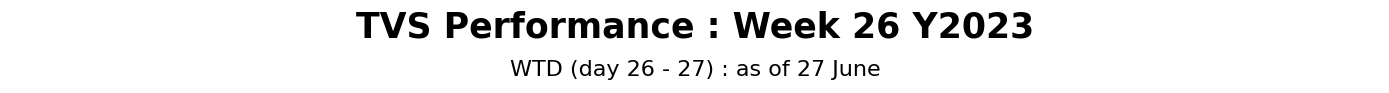

In [80]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

ax1.text(0.5, 0.5, f"TVS Performance : Week {curr_wk_label} Y{curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"WTD (day {wk_day_start} - {wk_day_end}) : as of {curr_day_label} {curr_mth_desc}", size=16, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

fig.tight_layout()
plt.show()

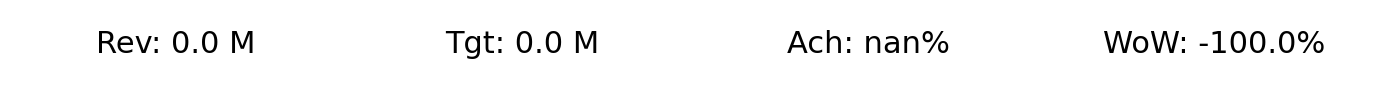

In [81]:
''' WTD Revenue '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Rev: {format(unit_mb(wtd_rev),',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(wtd_tgt),',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(wtd_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"WoW: {format(wtd_wow,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

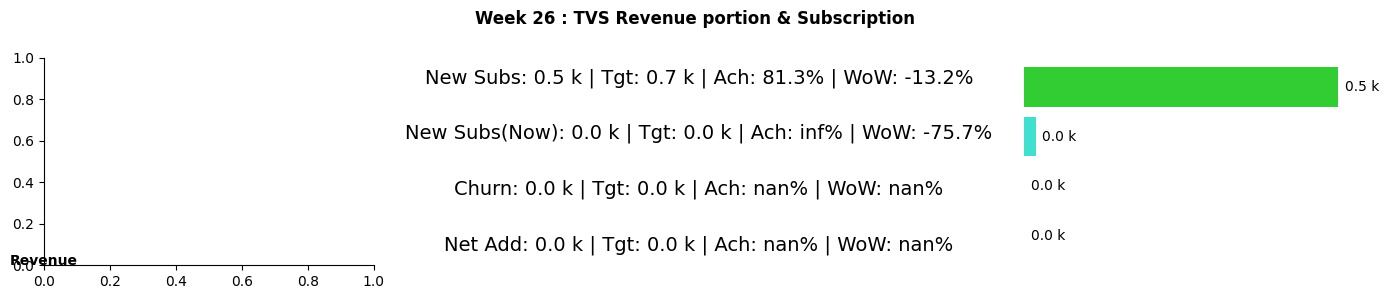

In [82]:
'''' Revenue Portion & Subscription '''

fig = plt.figure(figsize=(14, 3))
fig.suptitle(f'Week {curr_wk_label} : TVS Revenue portion & Subscription', weight='bold')
gs = GridSpec(4, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[2, 1])
ax5 = fig.add_subplot(gs[3, 1])
ax6 = fig.add_subplot(gs[:, 2])

''' ax1 '''
y = np.array([unit_mb(wtd_rev_new.sum()), unit_mb(wtd_rev_exist.sum())])
mylabels = [f"New: {format(y[0],',.0f')} m", f"Exist: {format(y[1],',.0f')} m"]
mycolors = ["lime", "lightsteelblue"]
# ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 3, "edgecolor": "white"})
ax1.text(0, 0, 'Revenue', ha='center', fontsize=10, weight='bold')

''' ax2 '''
ax2.text(0.5, 0.5, 
         f"New Subs: {format(unit_k(wtd_new_sub),',.1f')} k | Tgt: {format(unit_k(wtd_tgt_new_sub),',.1f')} k | Ach: {format(wtd_achv_new_sub,',.1%')} | WoW: {format(wtd_wow_new_sub,',.1%')}", 
         size=14, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

''' ax3 '''
ax3.text(0.5, 0.5, 
         f"New Subs(Now): {format(unit_k(wtd_new_sub_now),',.1f')} k | Tgt: {format(unit_k(wtd_tgt_new_sub_now),',.1f')} k | Ach: {format(wtd_achv_new_sub_now,',.1%')} | WoW: {format(wtd_wow_new_sub_now,',.1%')}", 
         size=14, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

''' ax4 '''
ax4.text(0.5, 0.5, 
         f"Churn: {format(unit_k(wtd_chrn_sub),',.1f')} k | Tgt: {format(unit_k(wtd_tgt_chrn_sub),',.1f')} k | Ach: {format(wtd_achv_chrn_sub,',.1%')} | WoW: {format(wtd_wow_chrn_sub,',.1%')}", 
         size=14, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

''' ax5 '''
ax5.text(0.5, 0.5, 
         f"Net Add: {format(unit_k(wtd_net_add),',.1f')} k | Tgt: {format(unit_k(wtd_tgt_net_add),',.1f')} k | Ach: {format(wtd_achv_net_add,',.1%')} | WoW: {format(wtd_wow_net_add,',.1%')}", 
         size=14, ha='center', va='center')
ax5.spines[['top','left','right','bottom']].set_visible(False)
ax5.set_axis_off()

''' ax6 '''
bars = ax6.barh(df_bar_h_wtd['METRIC_NAME'], width=unit_k(df_bar_h_wtd['VALUES']), color=df_bar_h_wtd['COLOR'])
ax6.bar_label(bars, padding=5, fmt='%.1f k')
ax6.spines[['top','left','right','bottom']].set_visible(False)
ax6 = plt.gca()
ax6.get_xaxis().set_visible(False)
ax6.get_yaxis().set_visible(False)

fig.tight_layout()
plt.show()

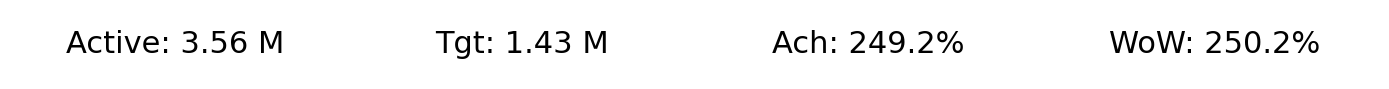

In [83]:
''' WTD Active Subs '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Active: {format(unit_mb(wtd_actv_sub),',.2f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(wtd_tgt_actv_sub),',.2f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(wtd_achv_actv_sub,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"WoW: {format(wtd_wow_actv_sub,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

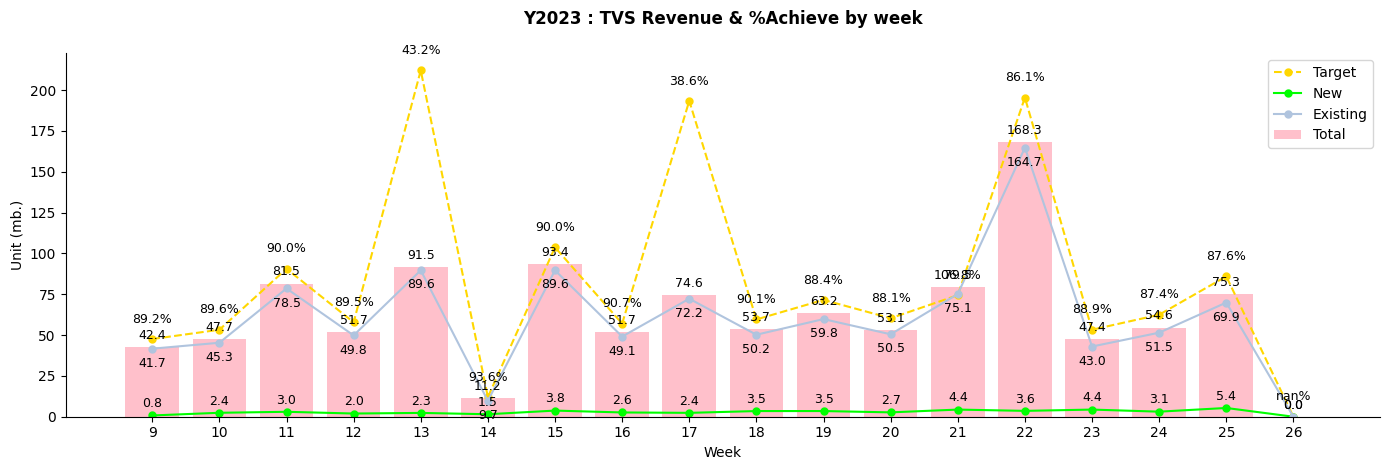

In [84]:
''' Revenue & Achieve by week '''

plt.figure().set_figwidth(14)
plt.title(f"Y{curr_yr} : TVS Revenue & %Achieve by week\n", weight='bold')

plt.bar(x_wk_axis, unit_mb(y_wk_act), label='Total', color='pink')
plt.plot(x_wk_axis, unit_mb(y_wk_tgt), marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
plt.plot(x_wk_axis, unit_mb(y_wk_act_new), marker='.', markeredgewidth=3, label='New', color='lime')
plt.plot(x_wk_axis, unit_mb(y_wk_act_exist), marker='.', markeredgewidth=3, label='Existing', color='lightsteelblue')
for i in x_wk_axis:
    plt.annotate(format(y_wk_achv[i],',.1%'), xy=(x_wk_axis[i], unit_mb(y_wk_tgt[i])+10), ha='center', fontsize=9)
    plt.annotate(format(unit_mb(y_wk_act[i]),',.1f'), xy=(x_wk_axis[i], unit_mb(y_wk_act[i])+5), ha='center', fontsize=9)
    plt.annotate(format(unit_mb(y_wk_act_new[i]),',.1f'), xy=(x_wk_axis[i], unit_mb(y_wk_act_new[i])+5), ha='center', fontsize=9)
    plt.annotate(format(unit_mb(y_wk_act_exist[i]),',.1f'), xy=(x_wk_axis[i], unit_mb(y_wk_act_exist[i])-5), ha='center', va='top', fontsize=9)

plt.xlabel('Week')
plt.ylabel('Unit (mb.)')
plt.xticks(x_wk_axis, x_wk)
plt.legend()
plt.tight_layout()
plt.show()

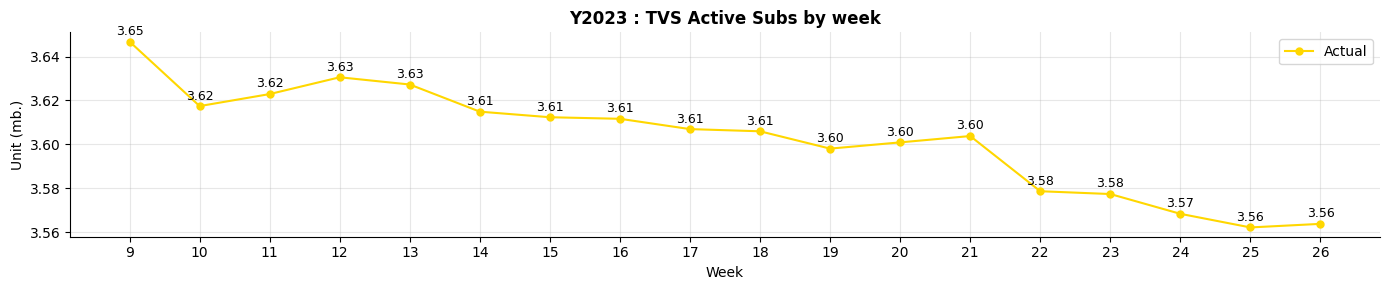

In [85]:
''' Active Subs by week '''

plt.figure(figsize=(14, 3))
plt.title(f"Y{curr_yr} : TVS Active Subs by week", weight='bold')

plt.plot(x_wk_axis, unit_mb(y_wk_act_actv_sub), marker='.', markeredgewidth=3, label='Actual', color='gold')
# plt.plot(x_wk_axis, unit_mb(y_wk_tgt_actv_sub), marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='grey')
for i in x_wk_axis:
    plt.annotate(format(unit_mb(y_wk_act_actv_sub[i]),',.2f'), xy=(x_wk_axis[i], unit_mb(y_wk_act_actv_sub[i])+0.003), ha='center', fontsize=9)
    # plt.annotate(f"Ach:{format(y_wk_achv_actv_sub[i],',.1%')}", xy=(x_wk_axis[i], unit_mb(y_wk_act_actv_sub[i])+0.03), ha='center', fontsize=8)
    # plt.annotate(f"WoW:{format(y_wk_wow_actv_sub[i],',.1%')}", xy=(x_wk_axis[i], unit_mb(y_wk_act_actv_sub[i])+0.02), ha='center', fontsize=8)

plt.xlabel('Week')
plt.ylabel('Unit (mb.)')
plt.xticks(x_wk_axis, x_wk)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

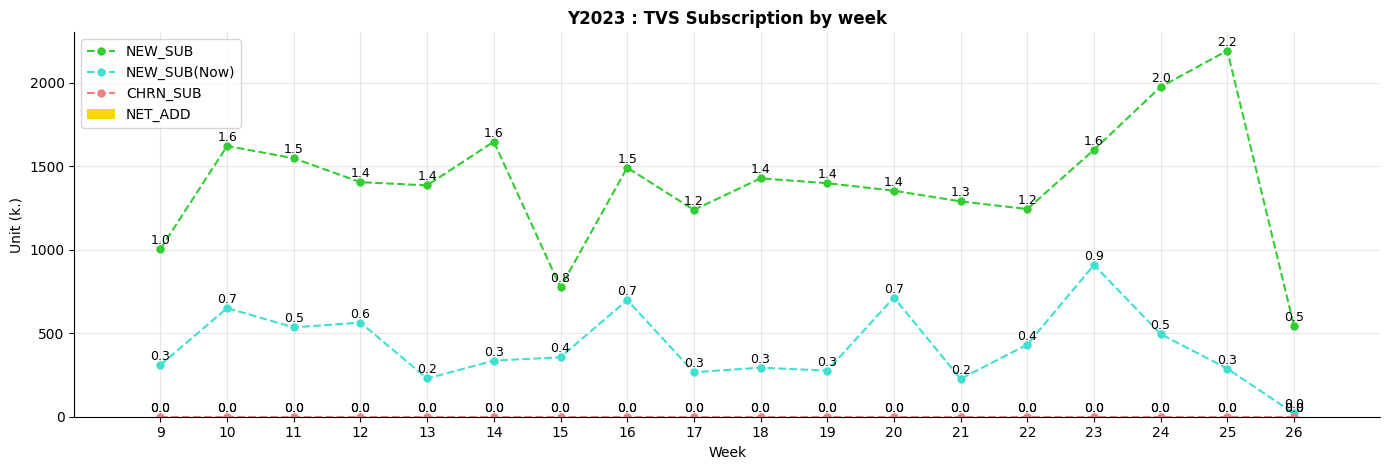

In [86]:
''' Subscription by week '''

plt.figure().set_figwidth(14)
plt.title(f"Y{curr_yr} : TVS Subscription by week", weight='bold')

plt.plot(x_wk_axis, y_wk_act_new_sub, marker='.', linestyle='dashed', markeredgewidth=3, label='NEW_SUB', color='limegreen')
plt.plot(x_wk_axis, y_wk_act_new_sub_now, marker='.', linestyle='dashed', markeredgewidth=3, label='NEW_SUB(Now)', color='turquoise')
plt.plot(x_wk_axis, y_wk_act_chrn_sub, marker='.', linestyle='dashed', markeredgewidth=3, label='CHRN_SUB', color='lightcoral')
plt.bar(x_wk_axis, y_wk_act_net_add, label='NET_ADD', color='gold')
for i in x_wk_axis:
    plt.annotate(format(unit_k(y_wk_act_new_sub[i]),',.1f'), xy=(x_wk_axis[i], y_wk_act_new_sub[i]+30), ha='center', fontsize=9)
    plt.annotate(format(unit_k(y_wk_act_new_sub_now[i]),',.1f'), xy=(x_wk_axis[i], y_wk_act_new_sub_now[i]+30), ha='center', fontsize=9)
    plt.annotate(format(unit_k(y_wk_act_chrn_sub[i]),',.1f'), xy=(x_wk_axis[i], y_wk_act_chrn_sub[i]+30), ha='center', fontsize=9)
    plt.annotate(format(unit_k(y_wk_act_net_add[i]),',.1f'), xy=(x_wk_axis[i], y_wk_act_net_add[i]+30), ha='center', fontsize=9)

plt.xlabel('Week')
plt.ylabel('Unit (k.)')
plt.xticks(x_wk_axis, x_wk)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## ** Daily (MTD) **

### DAY : Aggregation

In [87]:
''' Create Dataframe '''

df_rev_day_curr_mth = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==curr_mth].reset_index()

df_rev_day_curr_mth_clean = df_rev_day_curr_mth[df_rev_day_curr_mth['ACT']['TOTAL'] > 0].reset_index()

df_rev_day_curr_day = df_rev_day_curr_mth_clean.loc[df_rev_day_curr_mth_clean.groupby('TM_KEY_YR')['TM_KEY_DAY'].idxmax()]

df_rev_day_last_day = df_rev_day_curr_mth_clean.shift().loc[df_rev_day_curr_mth_clean.groupby('TM_KEY_YR')['TM_KEY_DAY'].idxmax()]

In [88]:
''' DTD Values '''

''' Last Period : Values '''
last_day_rev = df_rev_day_last_day['ACT']['TOTAL'].sum()
last_day_rev_new = df_rev_day_last_day['ACT']['NEW'].sum()
last_day_rev_exist = df_rev_day_last_day['ACT']['EXIST'].sum()
last_day_actv_sub = df_rev_day_last_day['ACT']['ACTV_SUB'].sum()
last_day_chrn_sub = df_rev_day_last_day['ACT']['CHRN_SUB'].sum()
last_day_net_add = df_rev_day_last_day['ACT']['NET_ADD'].sum()
last_day_new_sub = df_rev_day_last_day['ACT']['NEW_SUB'].sum()
last_day_new_sub_prem = df_rev_day_last_day['ACT']['NEW_SUB_PREM'].sum()
last_day_new_sub_mid = df_rev_day_last_day['ACT']['NEW_SUB_MID'].sum()
last_day_new_sub_mass = df_rev_day_last_day['ACT']['NEW_SUB_MASS'].sum()
last_day_new_sub_now = df_rev_day_last_day['ACT']['NEW_SUB_NOW'].sum()

''' TOTAL : Values '''
dtd_rev = df_rev_day_curr_day['ACT']['TOTAL'].sum()
dtd_tgt = df_rev_day_curr_day['TGT']['TOTAL'].sum()
dtd_achv = dtd_rev / dtd_tgt
dtd_last_rev = df_rev_day_last_day['ACT']['TOTAL'].sum()
dtd_dod = (dtd_rev / dtd_last_rev) - 1
dtd_gap = dtd_rev - dtd_last_rev

''' NEW : Values '''
dtd_rev_new = df_rev_day_curr_day['ACT']['NEW'].sum()
dtd_tgt_new = df_rev_day_curr_day['TGT']['NEW'].sum()
dtd_achv_new = dtd_rev_new / dtd_tgt_new
dtd_last_rev_new = df_rev_day_last_day['ACT']['NEW'].sum()
dtd_dod_new = (dtd_rev_new / dtd_last_rev_new) - 1
dtd_gap_new = dtd_rev_new - dtd_last_rev_new

''' EXIST : Values '''
dtd_rev_exist = df_rev_day_curr_day['ACT']['EXIST'].sum()
dtd_tgt_exist = df_rev_day_curr_day['TGT']['EXIST'].sum()
dtd_achv_exist = dtd_rev_exist / dtd_tgt_exist
dtd_last_rev_exist = df_rev_day_last_day['ACT']['EXIST'].sum()
dtd_dod_exist = (dtd_rev_exist / dtd_last_rev_exist) - 1
dtd_gap_exist = dtd_rev_exist - dtd_last_rev_exist

''' ACTV_SUB : Values '''
dtd_actv_sub = df_rev_day_agg[df_rev_day_agg['TM_KEY_DAY']==curr_day]['ACT']['ACTV_SUB'].sum()
dtd_tgt_actv_sub = df_rev_day_agg[df_rev_day_agg['TM_KEY_DAY']==curr_day]['TGT']['ACTV_SUB'].sum()
dtd_achv_actv_sub = dtd_actv_sub / dtd_tgt_actv_sub
dtd_last_actv_sub = df_rev_day_agg[df_rev_day_agg['TM_KEY_DAY']==last_day]['ACT']['ACTV_SUB'].sum()
dtd_dod_actv_sub = (dtd_actv_sub / dtd_last_actv_sub) - 1
dtd_gap_actv_sub = dtd_actv_sub - dtd_last_actv_sub

''' CHRN_SUB : Values '''
dtd_chrn_sub = df_rev_day_agg[df_rev_day_agg['TM_KEY_DAY']==curr_day]['ACT']['CHRN_SUB'].sum()
dtd_tgt_chrn_sub = df_rev_day_agg[df_rev_day_agg['TM_KEY_DAY']==curr_day]['TGT']['CHRN_SUB'].sum()
dtd_achv_chrn_sub = -((dtd_chrn_sub / dtd_tgt_chrn_sub) - 1)
dtd_last_chrn_sub = df_rev_day_agg[df_rev_day_agg['TM_KEY_DAY']==last_day]['ACT']['CHRN_SUB'].sum()
dtd_dod_chrn_sub = (dtd_chrn_sub / dtd_last_chrn_sub) - 1
dtd_gap_chrn_sub = dtd_chrn_sub - dtd_last_chrn_sub

''' NET_ADD : Values '''
dtd_net_add = df_rev_day_agg[df_rev_day_agg['TM_KEY_DAY']==curr_day]['ACT']['NET_ADD'].sum()
dtd_tgt_net_add = df_rev_day_agg[df_rev_day_agg['TM_KEY_DAY']==curr_day]['TGT']['NET_ADD'].sum()
dtd_achv_net_add = dtd_net_add / dtd_tgt_net_add
dtd_last_net_add = df_rev_day_agg[df_rev_day_agg['TM_KEY_DAY']==last_day]['ACT']['NET_ADD'].sum()
dtd_dod_net_add = (dtd_net_add / dtd_last_net_add) - 1
dtd_gap_net_add = dtd_net_add - dtd_last_net_add

''' NEW_SUB : Values '''
dtd_new_sub = df_rev_day_agg[df_rev_day_agg['TM_KEY_DAY']==curr_day]['ACT']['NEW_SUB'].sum()
dtd_tgt_new_sub = df_rev_day_agg[df_rev_day_agg['TM_KEY_DAY']==curr_day]['TGT']['NEW_SUB'].sum()
dtd_achv_new_sub = dtd_new_sub / dtd_tgt_new_sub
dtd_last_new_sub = df_rev_day_agg[df_rev_day_agg['TM_KEY_DAY']==last_day]['ACT']['NEW_SUB'].sum()
dtd_dod_new_sub = (dtd_new_sub / dtd_last_new_sub) - 1
dtd_gap_new_sub = dtd_new_sub - dtd_last_new_sub

''' NEW_SUB_PREM : Values '''
dtd_new_sub_prem = df_rev_day_agg[df_rev_day_agg['TM_KEY_DAY']==curr_day]['ACT']['NEW_SUB_PREM'].sum()
dtd_tgt_new_sub_prem = df_rev_day_agg[df_rev_day_agg['TM_KEY_DAY']==curr_day]['TGT']['NEW_SUB_PREM'].sum()
dtd_achv_new_sub_prem = dtd_new_sub_prem / dtd_tgt_new_sub_prem
dtd_last_new_sub_prem = df_rev_day_agg[df_rev_day_agg['TM_KEY_DAY']==last_day]['ACT']['NEW_SUB_PREM'].sum()
dtd_dod_new_sub_prem = (dtd_new_sub_prem / dtd_last_new_sub_prem) - 1
dtd_gap_new_sub_prem = dtd_new_sub_prem - dtd_last_new_sub_prem

''' NEW_SUB_MID : Values '''
dtd_new_sub_mid = df_rev_day_agg[df_rev_day_agg['TM_KEY_DAY']==curr_day]['ACT']['NEW_SUB_MID'].sum()
dtd_tgt_new_sub_mid = df_rev_day_agg[df_rev_day_agg['TM_KEY_DAY']==curr_day]['TGT']['NEW_SUB_MID'].sum()
dtd_achv_new_sub_mid = dtd_new_sub_mid / dtd_tgt_new_sub_mid
dtd_last_new_sub_mid = df_rev_day_agg[df_rev_day_agg['TM_KEY_DAY']==last_day]['ACT']['NEW_SUB_MID'].sum()
dtd_dod_new_sub_mid = (dtd_new_sub_mid / dtd_last_new_sub_mid) - 1
dtd_gap_new_sub_mid = dtd_new_sub_mid - dtd_last_new_sub_mid

''' NEW_SUB_MASS : Values '''
dtd_new_sub_mass = df_rev_day_agg[df_rev_day_agg['TM_KEY_DAY']==curr_day]['ACT']['NEW_SUB_MASS'].sum()
dtd_tgt_new_sub_mass = df_rev_day_agg[df_rev_day_agg['TM_KEY_DAY']==curr_day]['TGT']['NEW_SUB_MASS'].sum()
dtd_achv_new_sub_mass = dtd_new_sub_mass / dtd_tgt_new_sub_mass
dtd_last_new_sub_mass = df_rev_day_agg[df_rev_day_agg['TM_KEY_DAY']==last_day]['ACT']['NEW_SUB_MASS'].sum()
dtd_dod_new_sub_mass = (dtd_new_sub_mass / dtd_last_new_sub_mass) - 1
dtd_gap_new_sub_mass = dtd_new_sub_mass - dtd_last_new_sub_mass

''' NEW_SUB_NOW : Values '''
dtd_new_sub_now = df_rev_day_agg[df_rev_day_agg['TM_KEY_DAY']==curr_day]['ACT']['NEW_SUB_NOW'].sum()
dtd_tgt_new_sub_now = df_rev_day_agg[df_rev_day_agg['TM_KEY_DAY']==curr_day]['TGT']['NEW_SUB_NOW'].sum()
dtd_achv_new_sub_now = dtd_new_sub_now / dtd_tgt_new_sub_now
dtd_last_new_sub_now = df_rev_day_agg[df_rev_day_agg['TM_KEY_DAY']==last_day]['ACT']['NEW_SUB_NOW'].sum()
dtd_dod_new_sub_now = (dtd_new_sub_now / dtd_last_new_sub_now) - 1
dtd_gap_new_sub_now = dtd_new_sub_now - dtd_last_new_sub_now

C:\Users\Narut4\AppData\Local\Temp\ipykernel_10600\1162203681.py:51: RuntimeWarning: invalid value encountered in scalar divide
  dtd_achv_chrn_sub = -((dtd_chrn_sub / dtd_tgt_chrn_sub) - 1)
C:\Users\Narut4\AppData\Local\Temp\ipykernel_10600\1162203681.py:53: RuntimeWarning: invalid value encountered in scalar divide
  dtd_dod_chrn_sub = (dtd_chrn_sub / dtd_last_chrn_sub) - 1
C:\Users\Narut4\AppData\Local\Temp\ipykernel_10600\1162203681.py:59: RuntimeWarning: invalid value encountered in scalar divide
  dtd_achv_net_add = dtd_net_add / dtd_tgt_net_add
C:\Users\Narut4\AppData\Local\Temp\ipykernel_10600\1162203681.py:61: RuntimeWarning: invalid value encountered in scalar divide
  dtd_dod_net_add = (dtd_net_add / dtd_last_net_add) - 1
C:\Users\Narut4\AppData\Local\Temp\ipykernel_10600\1162203681.py:75: RuntimeWarning: divide by zero encountered in scalar divide
  dtd_achv_new_sub_prem = dtd_new_sub_prem / dtd_tgt_new_sub_prem
C:\Users\Narut4\AppData\Local\Temp\ipykernel_10600\1162203681.

In [89]:
''' DTD BarH Dataframe'''

df_bar_h_dtd = df_rev_day_agg[df_rev_day_agg['TM_KEY_DAY']==curr_day]['ACT'][['NEW_SUB', 'NEW_SUB_NOW', 'CHRN_SUB', 'NET_ADD']].T.reset_index()
df_bar_h_dtd.columns = ['METRIC_NAME', 'VALUES']

color_conditions = [df_bar_h_dtd['METRIC_NAME']=='NEW_SUB', 
                    df_bar_h_dtd['METRIC_NAME']=='NEW_SUB_NOW', 
                    df_bar_h_dtd['METRIC_NAME']=='CHRN_SUB', 
                    df_bar_h_dtd['METRIC_NAME']=='NET_ADD',]
color_results = ['limegreen', 'turquoise', 'lightcoral', 'gold']
sort_results = [1, 2, 3, 4]

df_bar_h_dtd['COLOR'] = np.select(color_conditions, color_results)
df_bar_h_dtd['SORT_NO'] = np.select(color_conditions, sort_results)

df_bar_h_dtd = df_bar_h_dtd.sort_values(by='SORT_NO', ascending=False)
df_bar_h_dtd

,METRIC_NAME,VALUES,COLOR,SORT_NO
3,NET_ADD,NaN,gold,4
2,CHRN_SUB,NaN,lightcoral,3
1,NEW_SUB_NOW,NaN,turquoise,2
0,NEW_SUB,253.0,limegreen,1


In [90]:
''' Day Chart Values '''

x_day = df_rev_day_curr_mth['DAY_LABEL']
x_day_axis = np.arange(len(x_day))

''' TOTAL : Values '''
y_day_act = df_rev_day_curr_mth['ACT']['TOTAL']
y_day_tgt = df_rev_day_curr_mth['TGT']['TOTAL']
y_day_achv = df_rev_day_curr_mth['%ACHV']['TOTAL']
y_day_gap = df_rev_day_curr_mth['GAP']['TOTAL']
y_day_diff = df_rev_day_curr_mth['DIFF']['TOTAL']
y_day_last_act = df_rev_day_curr_mth['LAST_ACT']['TOTAL']
y_day_dod = df_rev_day_curr_mth['%DOD']['TOTAL']

''' NEW : Values '''
y_day_act_new = df_rev_day_curr_mth['ACT']['NEW']
y_day_tgt_new = df_rev_day_curr_mth['TGT']['NEW']
y_day_achv_new = df_rev_day_curr_mth['%ACHV']['NEW']
y_day_gap_new = df_rev_day_curr_mth['GAP']['NEW']
y_day_diff_new = df_rev_day_curr_mth['DIFF']['NEW']
y_day_last_act_new = df_rev_day_curr_mth['LAST_ACT']['NEW']
y_day_dod_new = df_rev_day_curr_mth['%DOD']['NEW']

''' EXIST : Values '''
y_day_act_exist = df_rev_day_curr_mth['ACT']['EXIST']
y_day_tgt_exist = df_rev_day_curr_mth['TGT']['EXIST']
y_day_achv_exist = df_rev_day_curr_mth['%ACHV']['EXIST']
y_day_gap_exist = df_rev_day_curr_mth['GAP']['EXIST']
y_day_diff_exist = df_rev_day_curr_mth['DIFF']['EXIST']
y_day_last_act_exist = df_rev_day_curr_mth['LAST_ACT']['EXIST']
y_day_dod_exist = df_rev_day_curr_mth['%DOD']['EXIST']

''' ACTV_SUB : Values '''
y_day_act_actv_sub = df_rev_day_curr_mth['ACT']['ACTV_SUB']
y_day_tgt_actv_sub = df_rev_day_curr_mth['TGT']['ACTV_SUB']
y_day_achv_actv_sub = df_rev_day_curr_mth['%ACHV']['ACTV_SUB']
y_day_gap_actv_sub = df_rev_day_curr_mth['GAP']['ACTV_SUB']
y_day_diff_actv_sub = df_rev_day_curr_mth['DIFF']['ACTV_SUB']
y_day_last_act_actv_sub = df_rev_day_curr_mth['LAST_ACT']['ACTV_SUB']
y_day_dod_actv_sub = df_rev_day_curr_mth['%DOD']['ACTV_SUB']

''' CHRN_SUB : Values '''
y_day_act_chrn_sub = df_rev_day_curr_mth['ACT']['CHRN_SUB']
y_day_tgt_chrn_sub = df_rev_day_curr_mth['TGT']['CHRN_SUB']
y_day_achv_chrn_sub = df_rev_day_curr_mth['%ACHV']['CHRN_SUB']
y_day_gap_chrn_sub = df_rev_day_curr_mth['GAP']['CHRN_SUB']
y_day_diff_chrn_sub = df_rev_day_curr_mth['DIFF']['CHRN_SUB']
y_day_last_act_chrn_sub = df_rev_day_curr_mth['LAST_ACT']['CHRN_SUB']
y_day_dod_chrn_sub = df_rev_day_curr_mth['%DOD']['CHRN_SUB']

''' NET_ADD : Values '''
y_day_act_net_add = df_rev_day_curr_mth['ACT']['NET_ADD']
y_day_tgt_net_add = df_rev_day_curr_mth['TGT']['NET_ADD']
y_day_achv_net_add = df_rev_day_curr_mth['%ACHV']['NET_ADD']
y_day_gap_net_add = df_rev_day_curr_mth['GAP']['NET_ADD']
y_day_diff_net_add = df_rev_day_curr_mth['DIFF']['NET_ADD']
y_day_last_act_net_add = df_rev_day_curr_mth['LAST_ACT']['NET_ADD']
y_day_dod_net_add = df_rev_day_curr_mth['%DOD']['NET_ADD']

''' NEW_SUB : Values '''
y_day_act_new_sub = df_rev_day_curr_mth['ACT']['NEW_SUB']
y_day_tgt_new_sub = df_rev_day_curr_mth['TGT']['NEW_SUB']
y_day_achv_new_sub = df_rev_day_curr_mth['%ACHV']['NEW_SUB']
y_day_gap_new_sub = df_rev_day_curr_mth['GAP']['NEW_SUB']
y_day_diff_new_sub = df_rev_day_curr_mth['DIFF']['NEW_SUB']
y_day_last_act_new_sub = df_rev_day_curr_mth['LAST_ACT']['NEW_SUB']
y_day_dod_new_sub = df_rev_day_curr_mth['%DOD']['NEW_SUB']

''' NEW_SUB_PREM : Values '''
y_day_act_new_sub_prem = df_rev_day_curr_mth['ACT']['NEW_SUB_PREM']
y_day_tgt_new_sub_prem = df_rev_day_curr_mth['TGT']['NEW_SUB_PREM']
y_day_achv_new_sub_prem = df_rev_day_curr_mth['%ACHV']['NEW_SUB_PREM']
y_day_gap_new_sub_prem = df_rev_day_curr_mth['GAP']['NEW_SUB_PREM']
y_day_diff_new_sub_prem = df_rev_day_curr_mth['DIFF']['NEW_SUB_PREM']
y_day_last_act_new_sub_prem = df_rev_day_curr_mth['LAST_ACT']['NEW_SUB_PREM']
y_day_dod_new_sub_prem = df_rev_day_curr_mth['%DOD']['NEW_SUB_PREM']

''' NEW_SUB_MID : Values '''
y_day_act_new_sub_mid = df_rev_day_curr_mth['ACT']['NEW_SUB_MID']
y_day_tgt_new_sub_mid = df_rev_day_curr_mth['TGT']['NEW_SUB_MID']
y_day_achv_new_sub_mid = df_rev_day_curr_mth['%ACHV']['NEW_SUB_MID']
y_day_gap_new_sub_mid = df_rev_day_curr_mth['GAP']['NEW_SUB_MID']
y_day_diff_new_sub_mid = df_rev_day_curr_mth['DIFF']['NEW_SUB_MID']
y_day_last_act_new_sub_mid = df_rev_day_curr_mth['LAST_ACT']['NEW_SUB_MID']
y_day_dod_new_sub_mid = df_rev_day_curr_mth['%DOD']['NEW_SUB_MID']

''' NEW_SUB_MASS : Values '''
y_day_act_new_sub_mass = df_rev_day_curr_mth['ACT']['NEW_SUB_MASS']
y_day_tgt_new_sub_mass = df_rev_day_curr_mth['TGT']['NEW_SUB_MASS']
y_day_achv_new_sub_mass = df_rev_day_curr_mth['%ACHV']['NEW_SUB_MASS']
y_day_gap_new_sub_mass = df_rev_day_curr_mth['GAP']['NEW_SUB_MASS']
y_day_diff_new_sub_mass = df_rev_day_curr_mth['DIFF']['NEW_SUB_MASS']
y_day_last_act_new_sub_mass = df_rev_day_curr_mth['LAST_ACT']['NEW_SUB_MASS']
y_day_dod_new_sub_mass = df_rev_day_curr_mth['%DOD']['NEW_SUB_MASS']

''' NEW_SUB_NOW : Values '''
y_day_act_new_sub_now = df_rev_day_curr_mth['ACT']['NEW_SUB_NOW']
y_day_tgt_new_sub_now = df_rev_day_curr_mth['TGT']['NEW_SUB_NOW']
y_day_achv_new_sub_now = df_rev_day_curr_mth['%ACHV']['NEW_SUB_NOW']
y_day_gap_new_sub_now = df_rev_day_curr_mth['GAP']['NEW_SUB_NOW']
y_day_diff_new_sub_now = df_rev_day_curr_mth['DIFF']['NEW_SUB_NOW']
y_day_last_act_new_sub_now = df_rev_day_curr_mth['LAST_ACT']['NEW_SUB_NOW']
y_day_dod_new_sub_now = df_rev_day_curr_mth['%DOD']['NEW_SUB_NOW']

### DAY : Visualizations

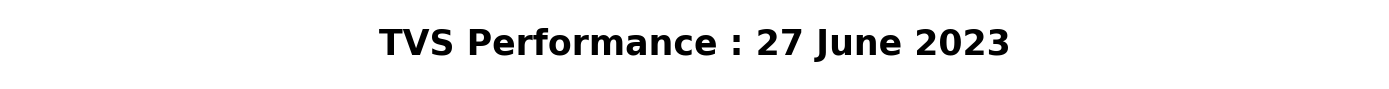

In [91]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 1)
ax1 = fig.add_subplot(gs[:, :])

ax1.text(0.5, 0.5, f"TVS Performance : {curr_day_label} {curr_mth_desc} {curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

fig.tight_layout()
plt.show()

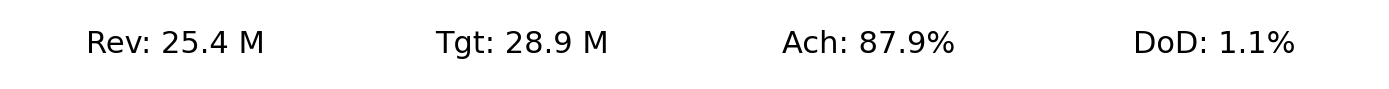

In [92]:
''' DTD Revenue '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Rev: {format(unit_mb(dtd_rev),',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(dtd_tgt),',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(dtd_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"DoD: {format(dtd_dod,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

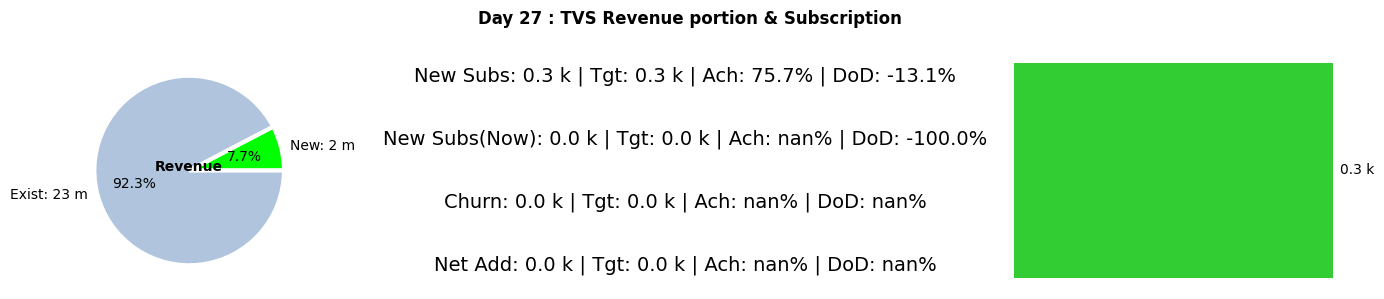

In [93]:
'''' Revenue Portion & Subscription '''

fig = plt.figure(figsize=(14, 3))
fig.suptitle(f'Day {curr_day_label} : TVS Revenue portion & Subscription', weight='bold')
gs = GridSpec(4, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[2, 1])
ax5 = fig.add_subplot(gs[3, 1])
ax6 = fig.add_subplot(gs[:, 2])

''' ax1 '''
y = np.array([unit_mb(dtd_rev_new.sum()), unit_mb(dtd_rev_exist.sum())])
mylabels = [f"New: {format(y[0],',.0f')} m", f"Exist: {format(y[1],',.0f')} m"]
mycolors = ["lime", "lightsteelblue"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 3, "edgecolor": "white"})
ax1.text(0, 0, 'Revenue', ha='center', fontsize=10, weight='bold')

''' ax2 '''
ax2.text(0.5, 0.5, 
         f"New Subs: {format(unit_k(dtd_new_sub),',.1f')} k | Tgt: {format(unit_k(dtd_tgt_new_sub),',.1f')} k | Ach: {format(dtd_achv_new_sub,',.1%')} | DoD: {format(dtd_dod_new_sub,',.1%')}", 
         size=14, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

''' ax3 '''
ax3.text(0.5, 0.5, 
         f"New Subs(Now): {format(unit_k(dtd_new_sub_now),',.1f')} k | Tgt: {format(unit_k(dtd_tgt_new_sub_now),',.1f')} k | Ach: {format(dtd_achv_new_sub_now,',.1%')} | DoD: {format(dtd_dod_new_sub_now,',.1%')}", 
         size=14, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

''' ax4 '''
ax4.text(0.5, 0.5, 
         f"Churn: {format(unit_k(dtd_chrn_sub),',.1f')} k | Tgt: {format(unit_k(dtd_tgt_chrn_sub),',.1f')} k | Ach: {format(dtd_achv_chrn_sub,',.1%')} | DoD: {format(dtd_dod_chrn_sub,',.1%')}", 
         size=14, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

''' ax5 '''
ax5.text(0.5, 0.5, 
         f"Net Add: {format(unit_k(dtd_net_add),',.1f')} k | Tgt: {format(unit_k(dtd_tgt_net_add),',.1f')} k | Ach: {format(dtd_achv_net_add,',.1%')} | DoD: {format(dtd_dod_net_add,',.1%')}", 
         size=14, ha='center', va='center')
ax5.spines[['top','left','right','bottom']].set_visible(False)
ax5.set_axis_off()

''' ax6 '''
bars = ax6.barh(df_bar_h_dtd['METRIC_NAME'], width=unit_k(df_bar_h_dtd['VALUES']), color=df_bar_h_dtd['COLOR'])
ax6.bar_label(bars, padding=5, fmt='%.1f k')
ax6.spines[['top','left','right','bottom']].set_visible(False)
ax6 = plt.gca()
ax6.get_xaxis().set_visible(False)
ax6.get_yaxis().set_visible(False)

fig.tight_layout()
plt.show()

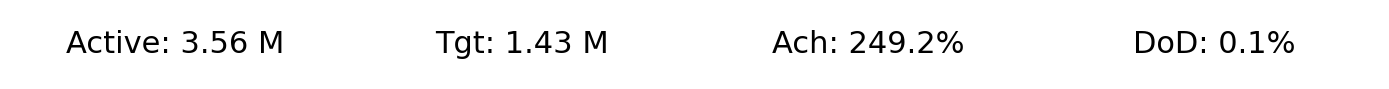

In [94]:
''' DTD Active Subs '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Active: {format(unit_mb(dtd_actv_sub),',.2f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(dtd_tgt_actv_sub),',.2f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(dtd_achv_actv_sub,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"DoD: {format(dtd_dod_actv_sub,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

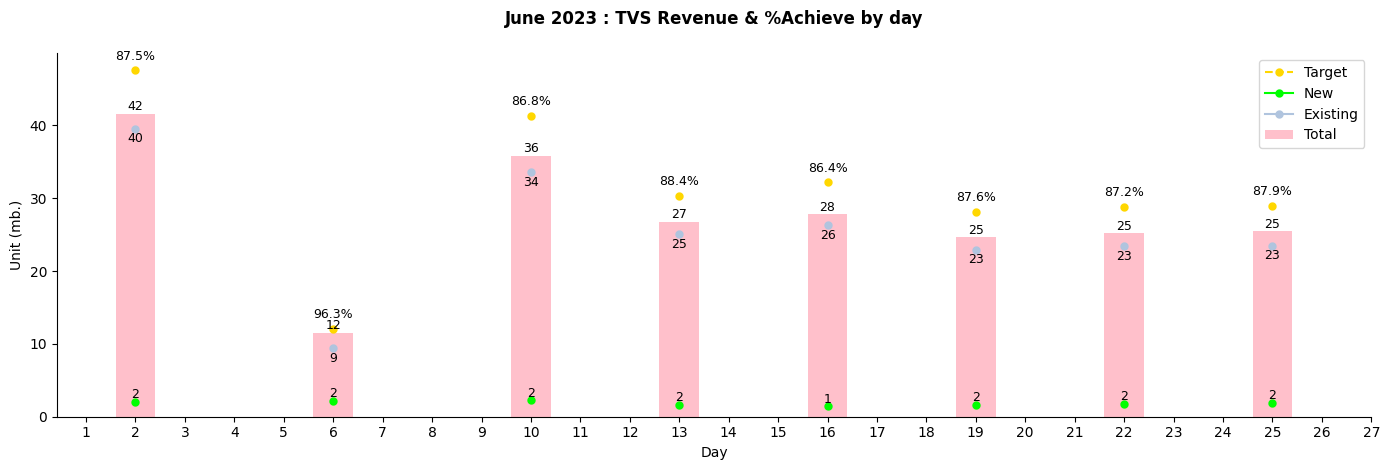

In [95]:
''' Revenue & Achieve by day '''

plt.figure().set_figwidth(14)
plt.title(f"{curr_mth_desc} {curr_yr} : TVS Revenue & %Achieve by day\n", weight='bold')

plt.bar(x_day_axis, unit_mb(y_day_act), label='Total', color='pink')
plt.plot(x_day_axis, unit_mb(y_day_tgt), marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
plt.plot(x_day_axis, unit_mb(y_day_act_new), marker='.', markeredgewidth=3, label='New', color='lime')
plt.plot(x_day_axis, unit_mb(y_day_act_exist), marker='.', markeredgewidth=3, label='Existing', color='lightsteelblue')
for i in x_day_axis:
    plt.annotate(format(y_day_achv[i],',.1%'), xy=(x_day_axis[i], unit_mb(y_day_tgt[i])+1.5), ha='center', fontsize=9)
    plt.annotate(format(unit_mb(y_day_act[i]),',.0f'), xy=(x_day_axis[i], unit_mb(y_day_act[i])+0.5), ha='center', fontsize=9)
    plt.annotate(format(unit_mb(y_day_act_new[i]),',.0f'), xy=(x_day_axis[i], unit_mb(y_day_act_new[i])+0.5), ha='center', fontsize=9)
    plt.annotate(format(unit_mb(y_day_act_exist[i]),',.0f'), xy=(x_day_axis[i], unit_mb(y_day_act_exist[i])-0.5), ha='center', va='top', fontsize=9)

plt.xlabel('Day')
plt.ylabel('Unit (mb.)')
plt.xticks(x_day_axis, x_day)
plt.legend()
plt.tight_layout()
plt.show()

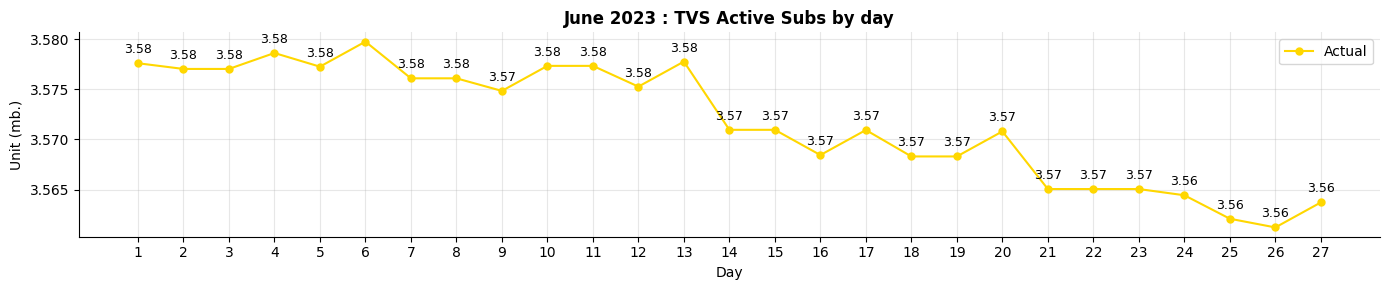

In [96]:
''' Active Subs by day '''

plt.figure(figsize=(14, 3))
plt.title(f"{curr_mth_desc} {curr_yr} : TVS Active Subs by day", weight='bold')

plt.plot(x_day_axis, unit_mb(y_day_act_actv_sub), marker='.', markeredgewidth=3, label='Actual', color='gold')
# plt.plot(x_day_axis, unit_mb(y_day_tgt_actv_sub), marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='grey')
for i in x_day_axis:
    plt.annotate(format(unit_mb(y_day_act_actv_sub[i]),',.2f'), xy=(x_day_axis[i], unit_mb(y_day_act_actv_sub[i])+0.001), ha='center', fontsize=9)

plt.xlabel('Day')
plt.ylabel('Unit (mb.)')
plt.xticks(x_day_axis, x_day)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

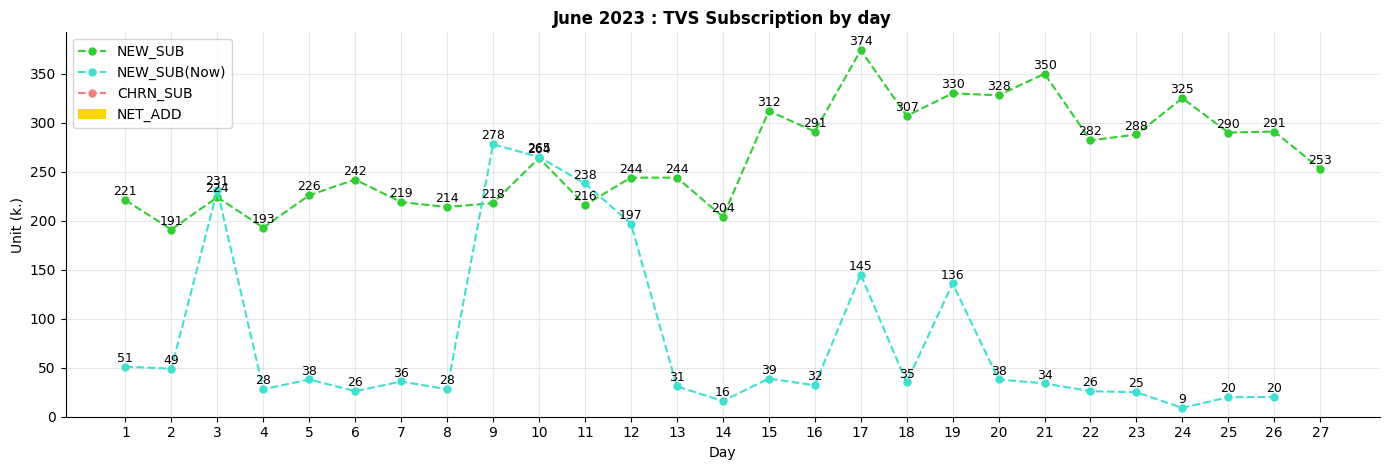

In [97]:
''' Subscription by day '''

plt.figure().set_figwidth(14)
plt.title(f"{curr_mth_desc} {curr_yr} : TVS Subscription by day", weight='bold')

plt.plot(x_day_axis, y_day_act_new_sub, marker='.', linestyle='dashed', markeredgewidth=3, label='NEW_SUB', color='limegreen')
plt.plot(x_day_axis, y_day_act_new_sub_now, marker='.', linestyle='dashed', markeredgewidth=3, label='NEW_SUB(Now)', color='turquoise')
plt.plot(x_day_axis, y_day_act_chrn_sub, marker='.', linestyle='dashed', markeredgewidth=3, label='CHRN_SUB', color='lightcoral')
plt.bar(x_day_axis, y_day_act_net_add, label='NET_ADD', color='gold')
for i in x_day_axis:
    plt.annotate(format(y_day_act_new_sub[i],',.0f'), xy=(x_day_axis[i], y_day_act_new_sub[i]+5), ha='center', fontsize=9)
    plt.annotate(format(y_day_act_new_sub_now[i],',.0f'), xy=(x_day_axis[i], y_day_act_new_sub_now[i]+5), ha='center', fontsize=9)
    plt.annotate(format(y_day_act_chrn_sub[i],',.0f'), xy=(x_day_axis[i], y_day_act_chrn_sub[i]+5), ha='center', fontsize=9)
    plt.annotate(format(y_day_act_net_add[i],',.0f'), xy=(x_day_axis[i], y_day_act_net_add[i]+5), ha='center', fontsize=9)

plt.xlabel('Day')
plt.ylabel('Unit (k.)')
plt.xticks(x_day_axis, x_day)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()